In [267]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from sklearn.linear_model import LinearRegression


In [268]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')  # Needed because matplotlib uses idiotic color management.

In [291]:
import sklearn.metrics as skmet
import scipy.stats

# Auto_sklearn Models

In [270]:
res = pd.read_csv("correct_choices.csv")
res

dataset    lr_acc  lr_auroc  knn_pca_acc  knn_pca_auroc  rf_pca_acc  \
0  birth_randoms  0.777966  0.833898     0.831073       0.871186    0.724294   
1   ring_randoms  0.842373  0.836723     0.700000       0.669492    0.546328   
2  adult_randoms  0.779661  0.885876     0.663842       0.722599    0.718644   
3  heart_randoms  0.942938  0.904520     0.774011       0.879096    0.644633   

   rf_pca_auroc  
0      0.858757  
1      0.614124  
2      0.837288  
3      0.648023

In [271]:
birth = pd.read_csv("birth_randoms/metrics.csv").drop(["lr_acc", "auroc"], axis=1)
ring = pd.read_csv("ring_randoms/metrics.csv").drop(["lr_acc", "auroc"], axis=1)
adult = pd.read_csv("adult_randoms/metrics.csv").drop(["lr_acc", "auroc"], axis=1)
heart = pd.read_csv("heart_randoms/metrics.csv").drop(["lr_acc", "auroc"], axis=1)

birth_accs = pd.read_csv("birth_randoms/accuracy_results.csv")
ring_accs = pd.read_csv("ring_randoms/accuracy_results.csv")
adult_accs = pd.read_csv("adult_randoms/accuracy_results.csv")
heart_accs = pd.read_csv("heart_randoms/accuracy_results.csv")

metrics = pd.concat([birth, ring, adult, heart], keys=["birth", "ring", "adult", "heart"], 
                    names=["dataset"], sort=False).reset_index().drop("level_1", axis=1)
accs = pd.concat([birth_accs, ring_accs, adult_accs, heart_accs], keys=["birth", "ring", "adult", "heart"], 
                 names=["dataset"], sort=False)
accs = accs.drop(["knn_acc", "knn_auroc", "rf_acc", "rf_auroc", "lr_pca_acc", "lr_pca_auroc"], 
                 axis=1).reset_index().drop("level_1", axis=1)
accs

dataset              algo   no  knn_pca_auroc  knn_pca_acc  rf_pca_auroc  \
0      birth           datafly    1       0.464272     0.406780      0.568481   
1      birth  datafly_shuffled    1       0.589675     0.440678      0.613460   
2      birth          mondrian    1       0.621924     0.450847      0.643375   
3      birth           datafly    2       0.441660     0.335593      0.596937   
4      birth  datafly_shuffled    2       0.464272     0.406780      0.578368   
...      ...               ...  ...            ...          ...           ...   
2395   heart  datafly_shuffled  199       0.579031     0.856557      0.668391   
2396   heart          mondrian  199       0.613002     0.844262      0.676950   
2397   heart           datafly  200       0.648956     0.856557      0.653968   
2398   heart  datafly_shuffled  200       0.648956     0.856557      0.654409   
2399   heart          mondrian  200       0.560173     0.856557      0.671018   

      rf_pca_acc  lr_auroc    lr_acc  
0       0.437288  0.583774  0.430508  
1       0.437288  0.619309  0.477966  
2       0.474576  0.627022  0.461017  
3       0.437288  0.603186  0.433898  
4       0.437288  0.583774  0.430508  
...          ...       ...       ...  
2395    0.856557  0.675628  0.855191  
2396    0.856557  0.508012  0.730874  
2397    0.856557  0.653285  0.857923  
2398    0.856557  0.653285  0.857923  
2399    0.856557  0.575013  0.711749  

[2400 rows x 9 columns]

# Metric plots
Ici, les plots des metrics vs. les differentes mesures d'utilité. Chaque dataset a un marker different, et une regression lineaire dessus de la couleur correspondante

In [272]:
plot_info = [(birth, birth_accs, "b", "x", "birth"),
            (ring, ring_accs, "r", "o", "ring"),
            (adult, adult_accs, "g", "+", "adult"),
            (heart, heart_accs, "y", "*", "heart")]

def plot_metric(metric, target_var):    
    plt.figure(figsize=(12,8))
    
    for dataset, acc_set, col, mark, label in plot_info:
        plt.scatter(dataset[metric], acc_set[target_var], c=col, marker=mark, alpha=0.5, label=label)
        
        X = dataset[metric].values.reshape(-1,1)
        y = acc_set[target_var]
        
        lin_reg = LinearRegression().fit(X, y)
        #print(label, lin_reg.coef_, lin_reg.intercept_)
        x=[[0],[1]]
        plt.plot(x, lin_reg.predict(x), c=col)

        plt.title(f"{metric} vs. {target_var}")
        plt.xlabel(metric)
        plt.ylabel(target_var)
        plt.legend()


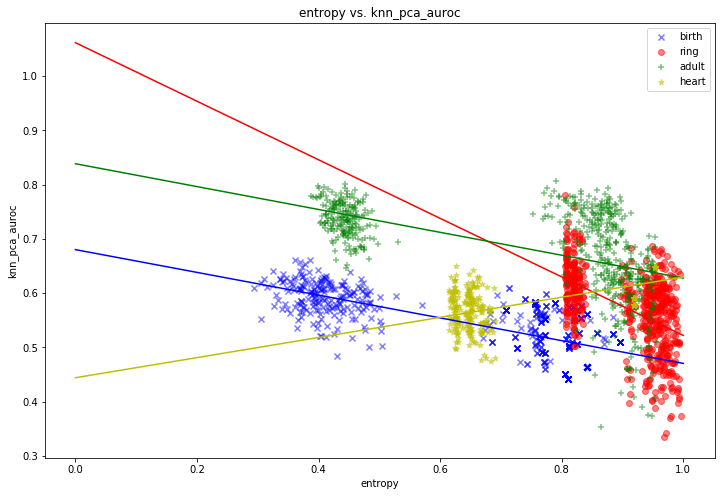

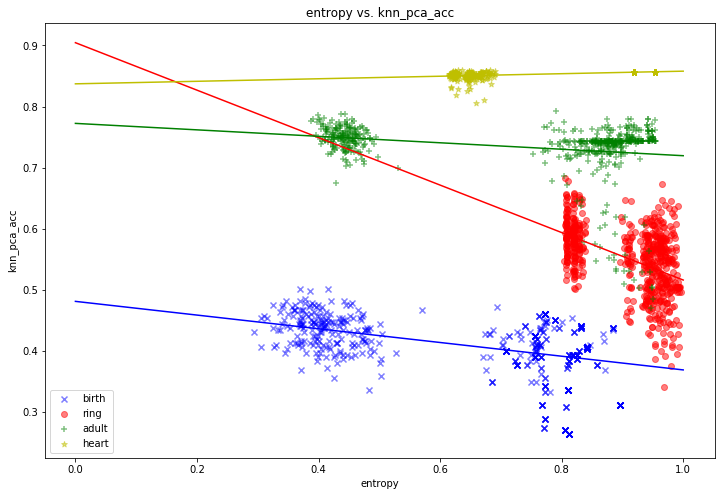

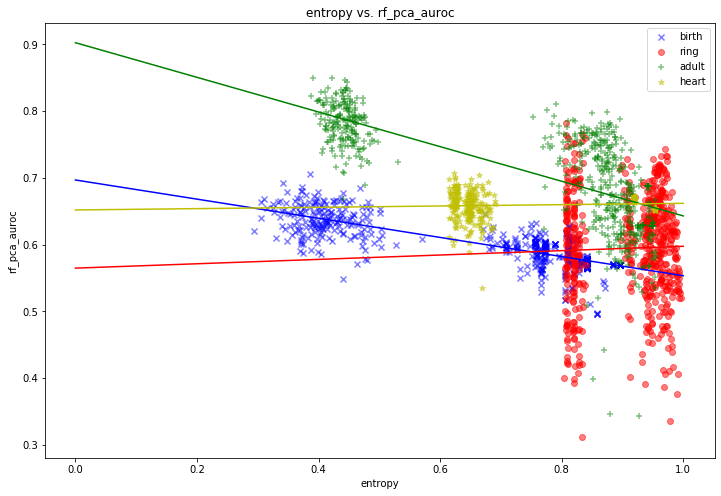

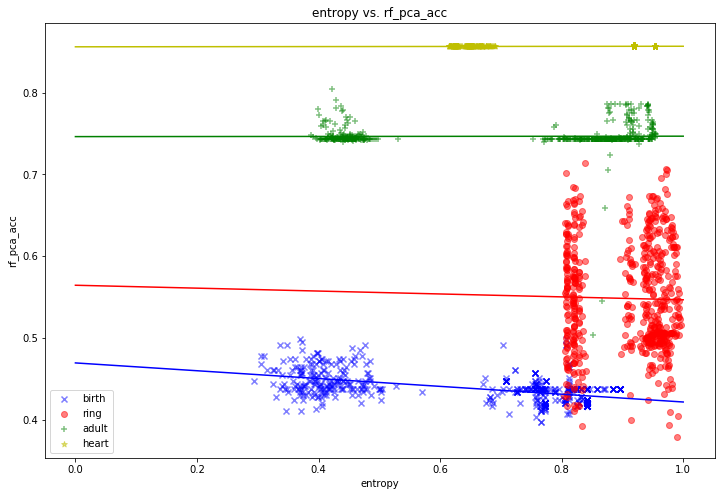

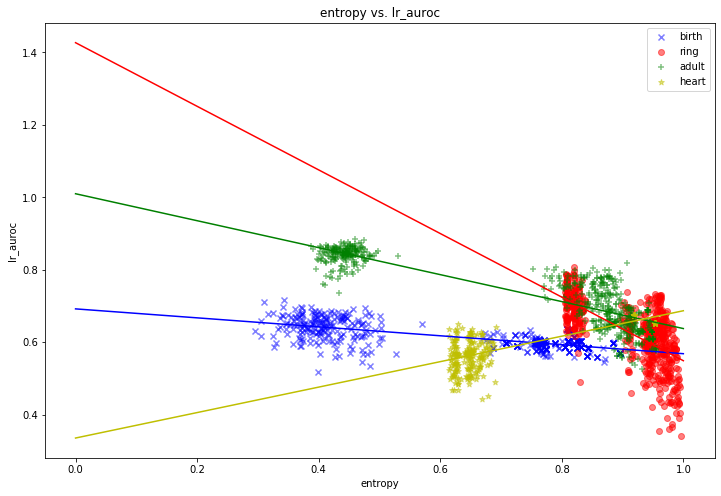

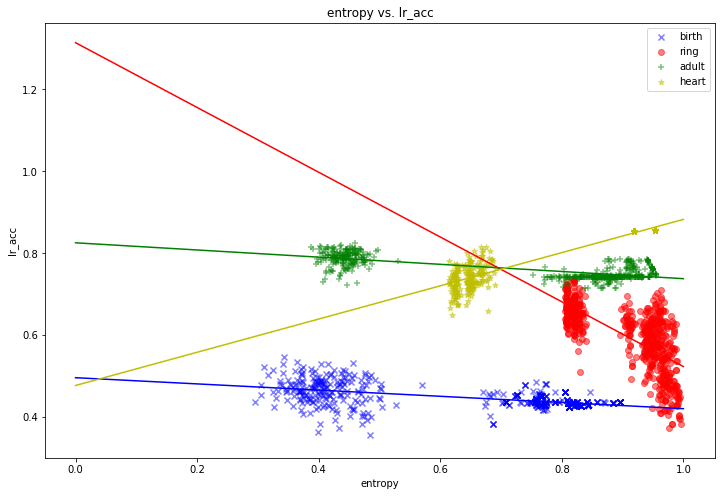

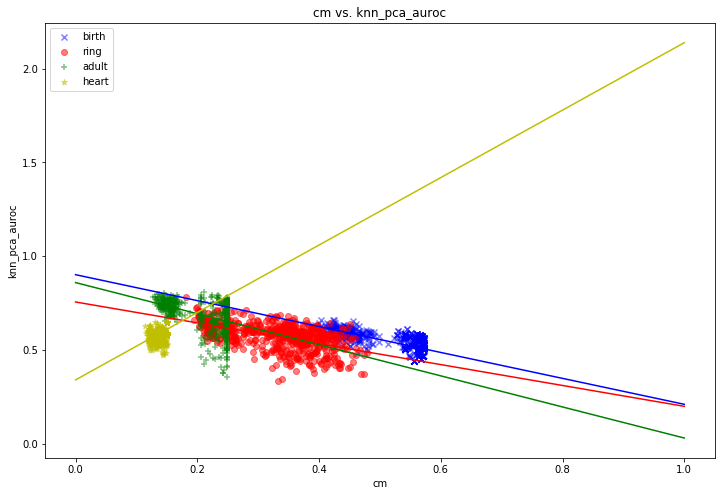

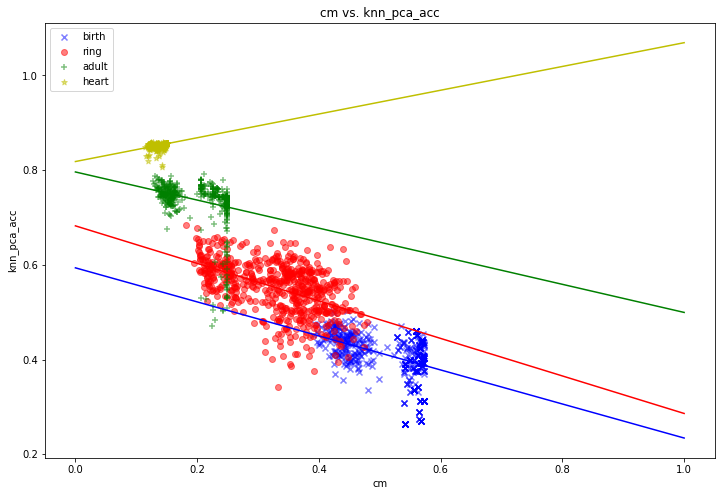

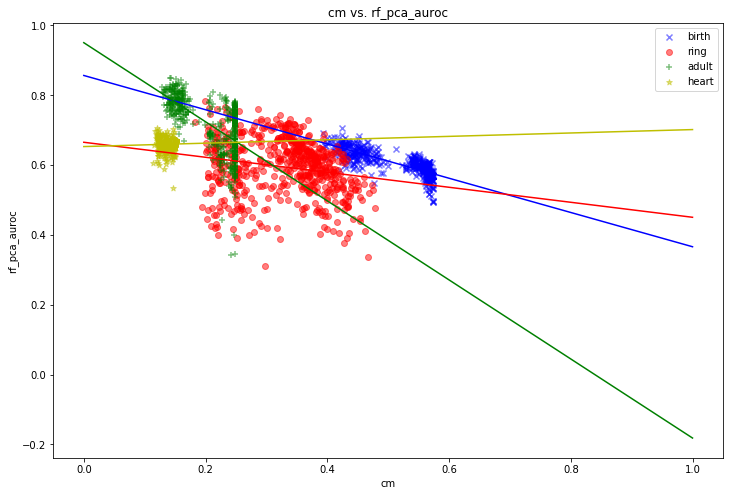

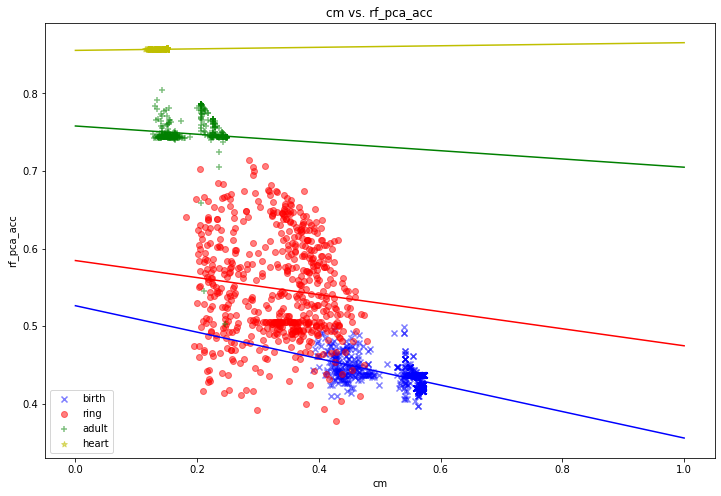

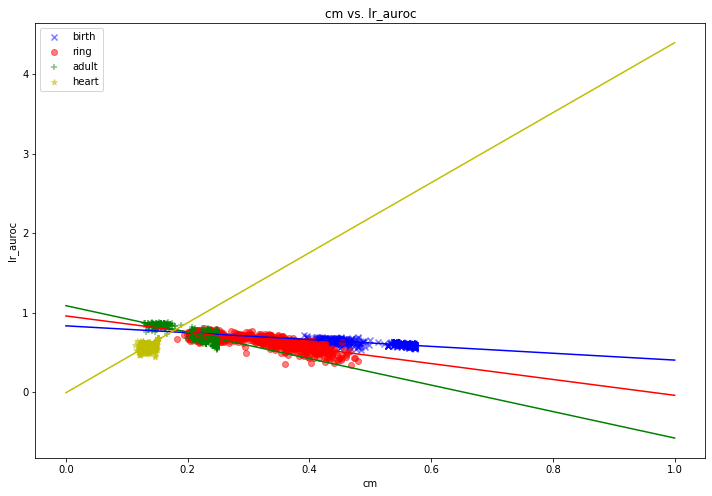

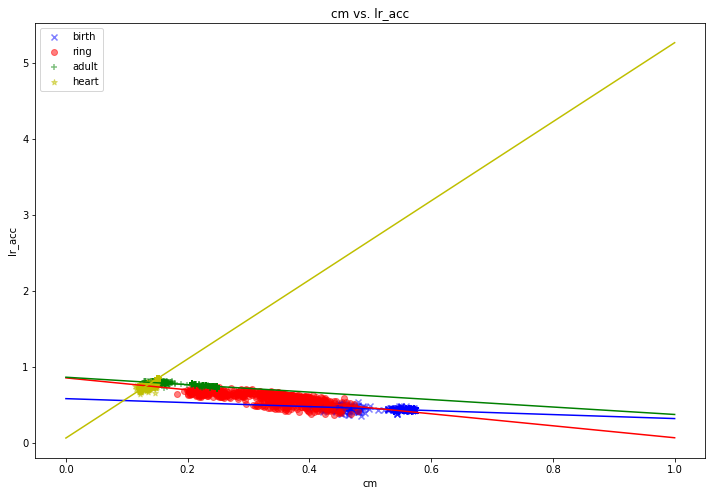

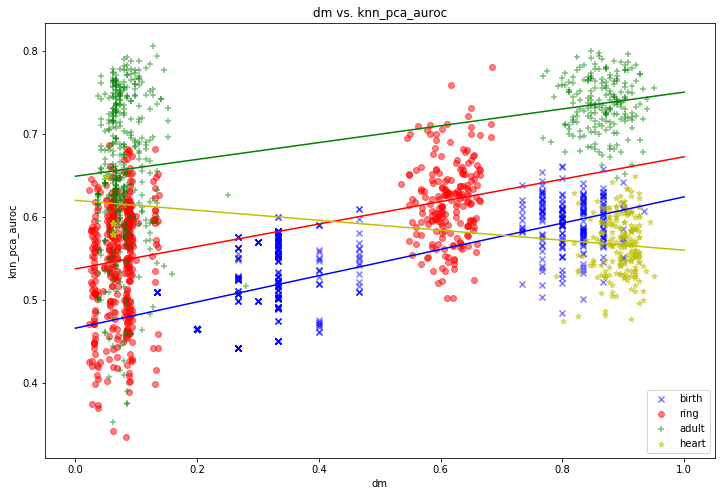

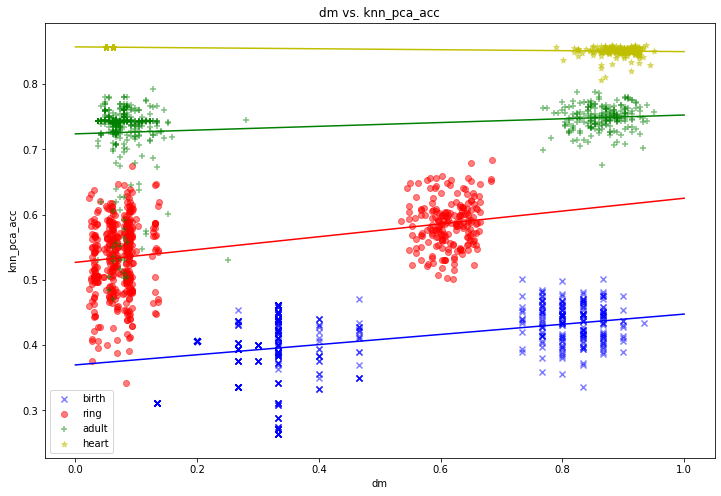

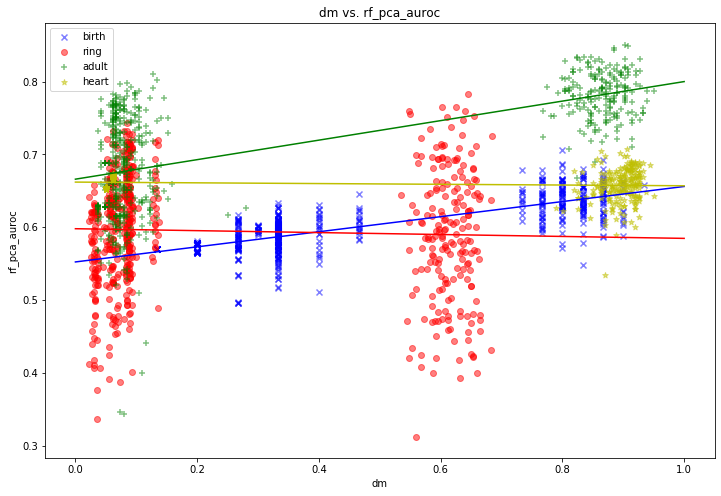

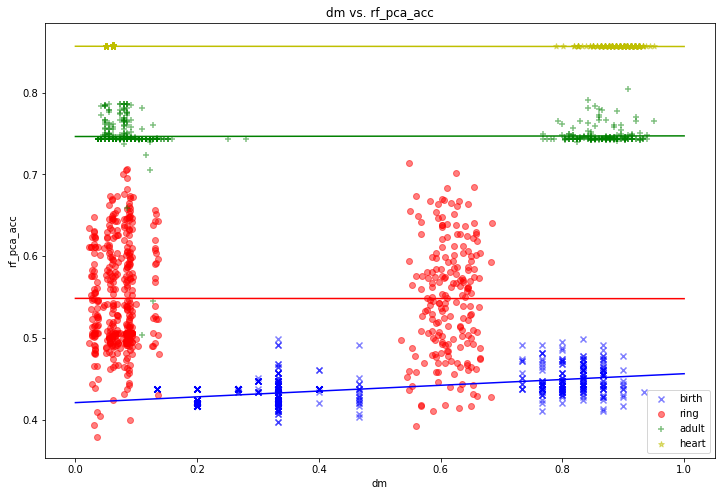

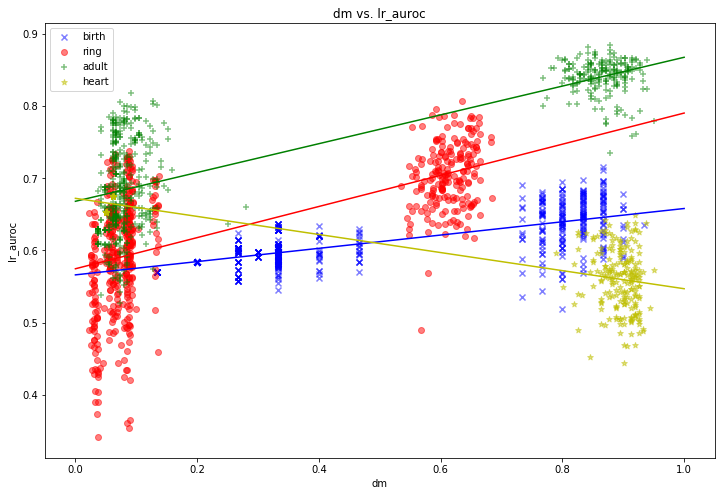

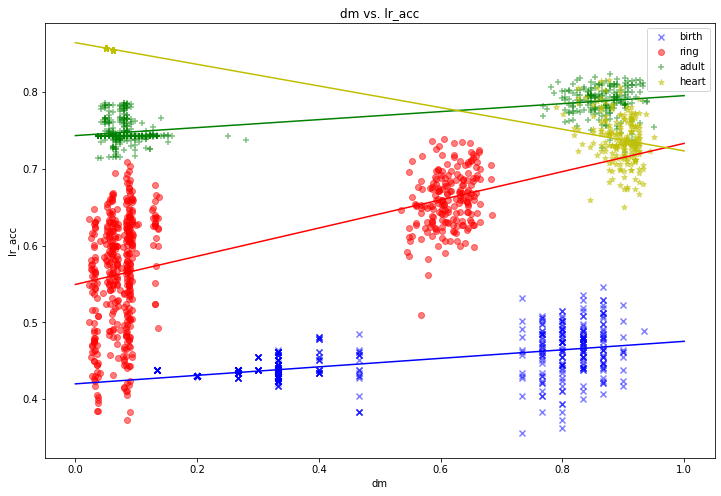

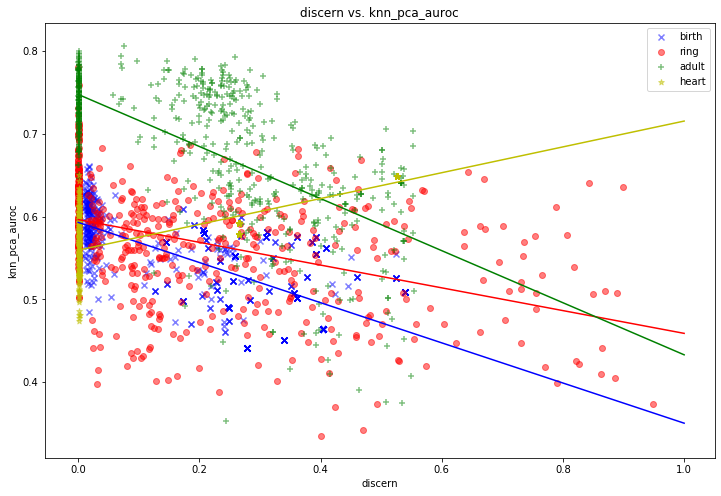

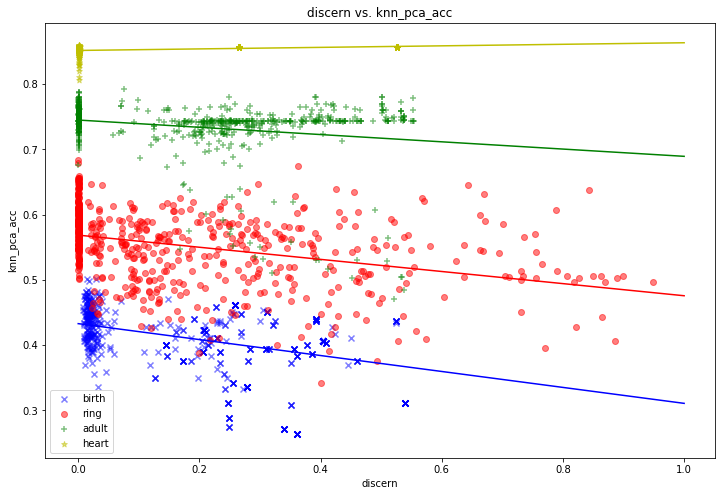

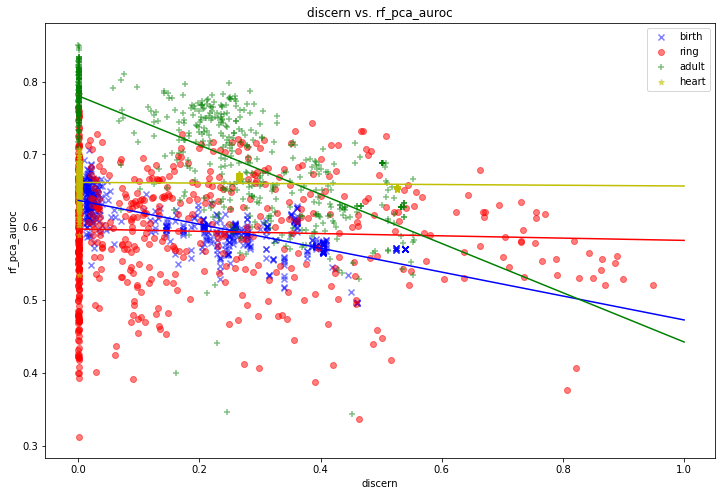

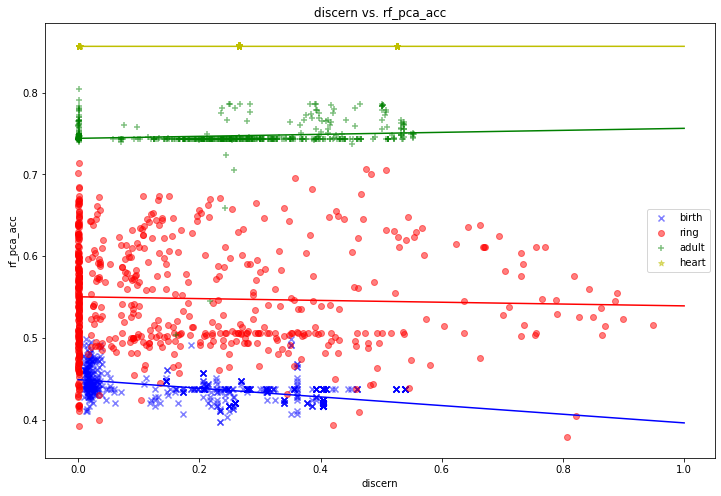

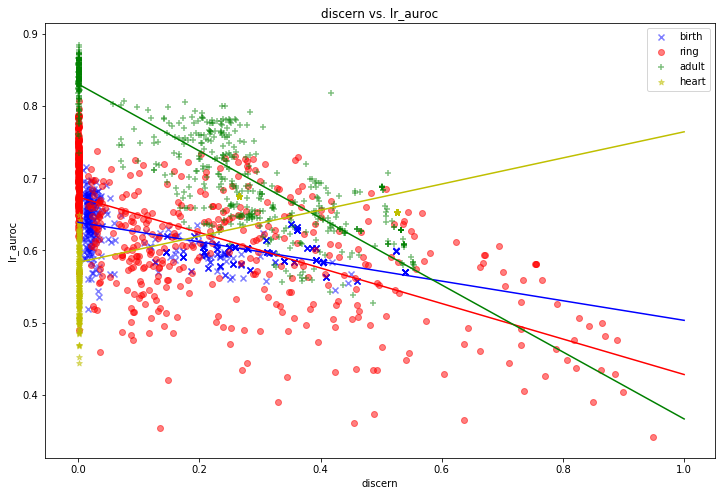

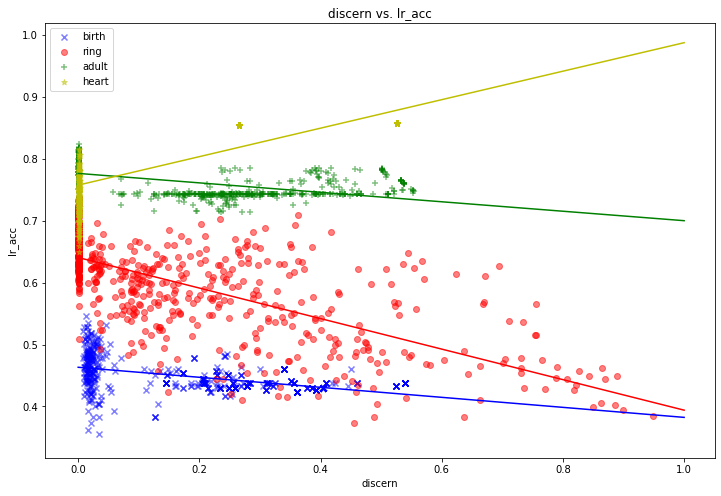

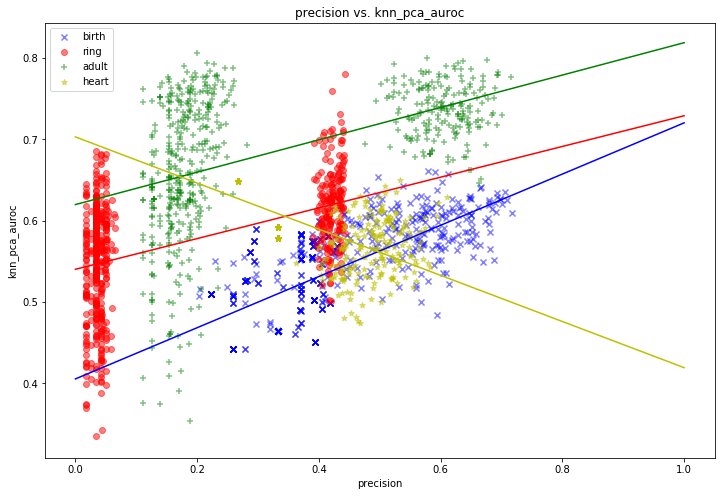

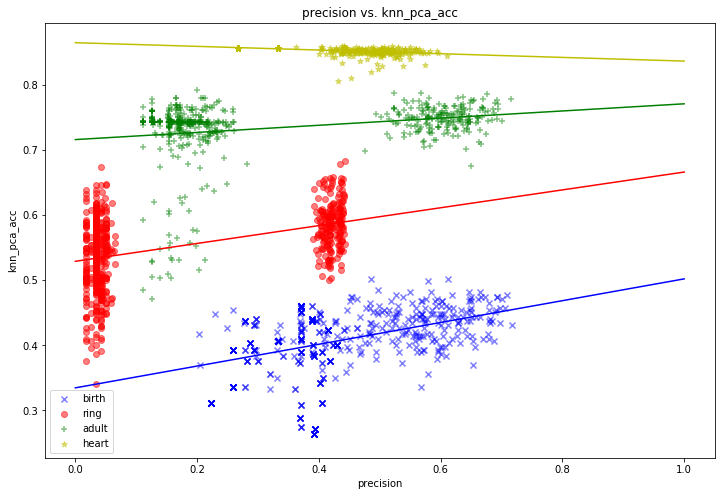

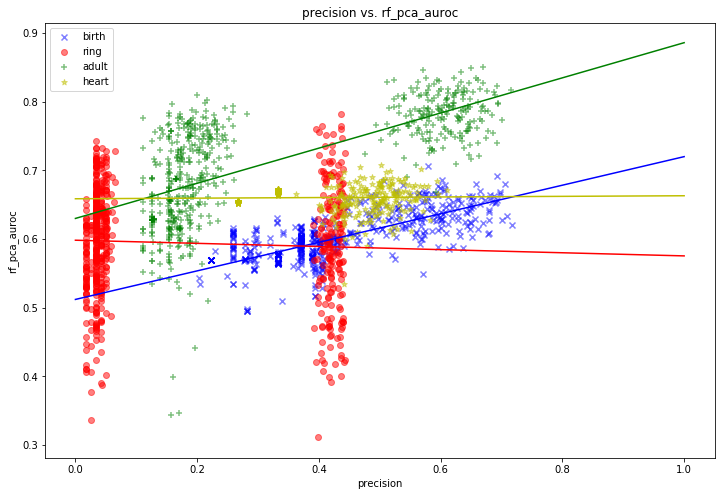

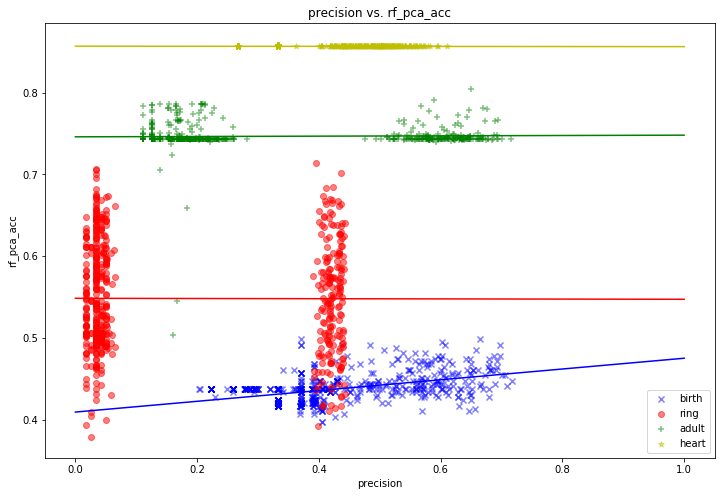

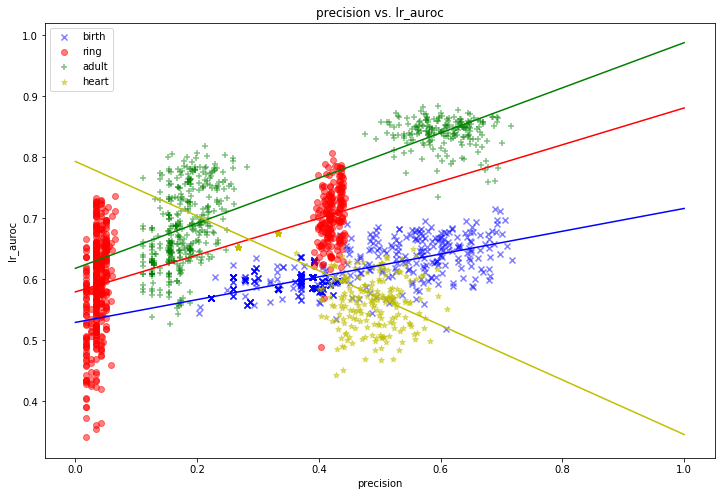

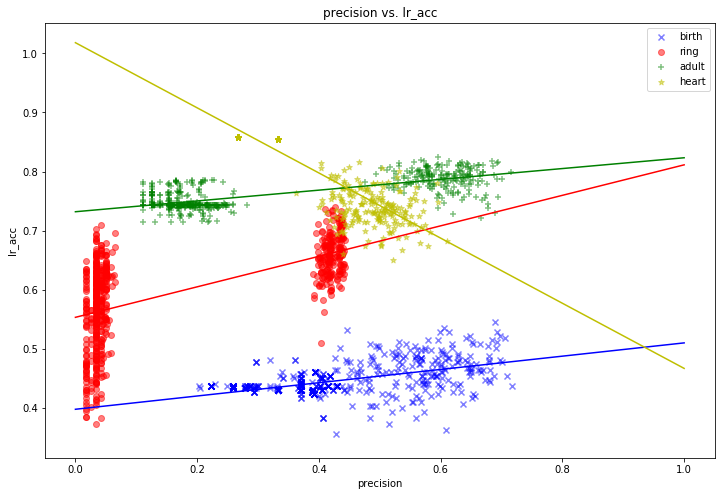

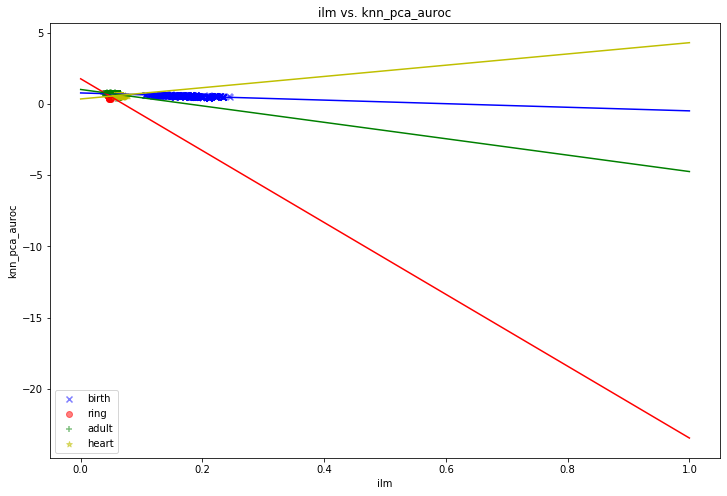

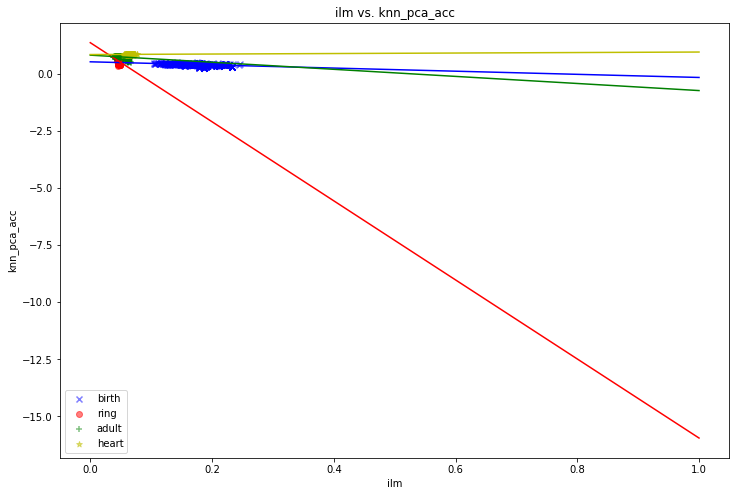

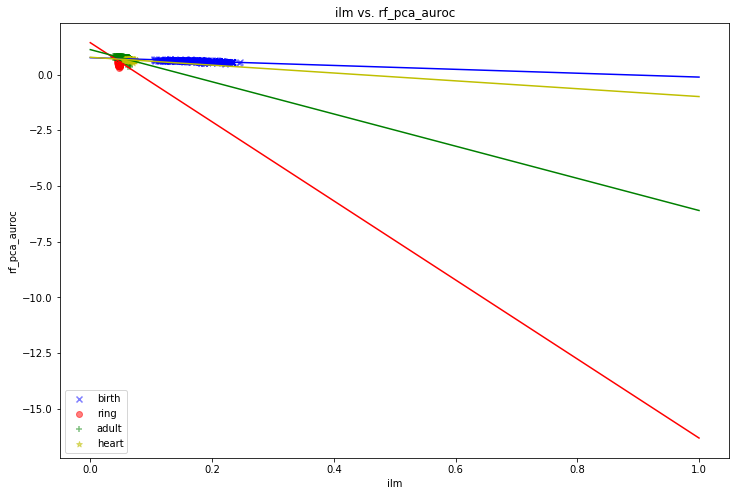

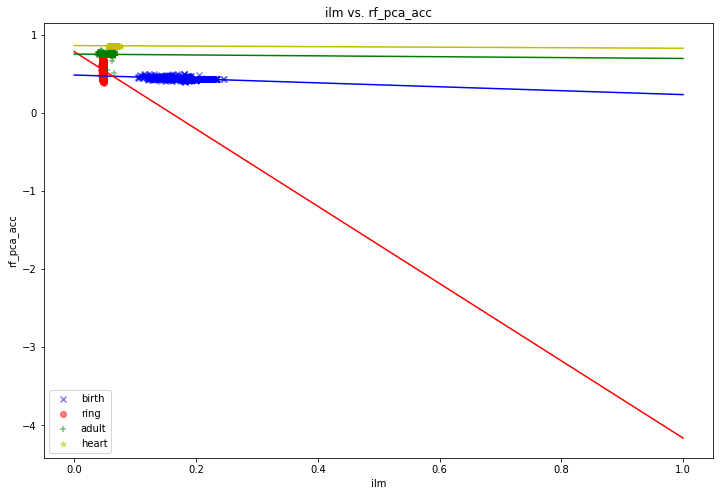

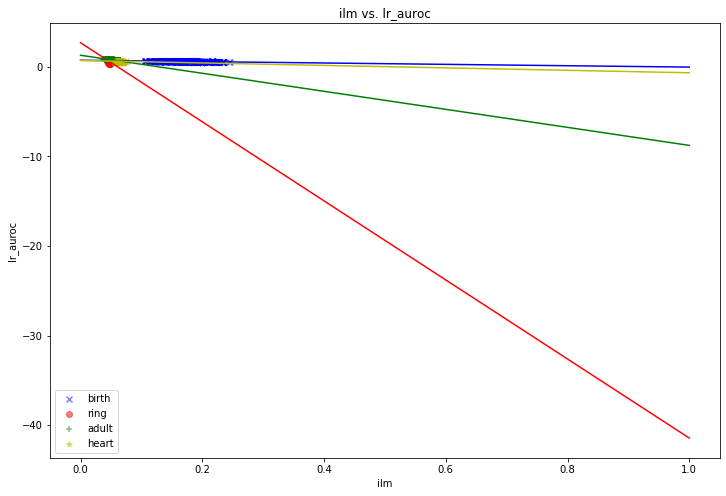

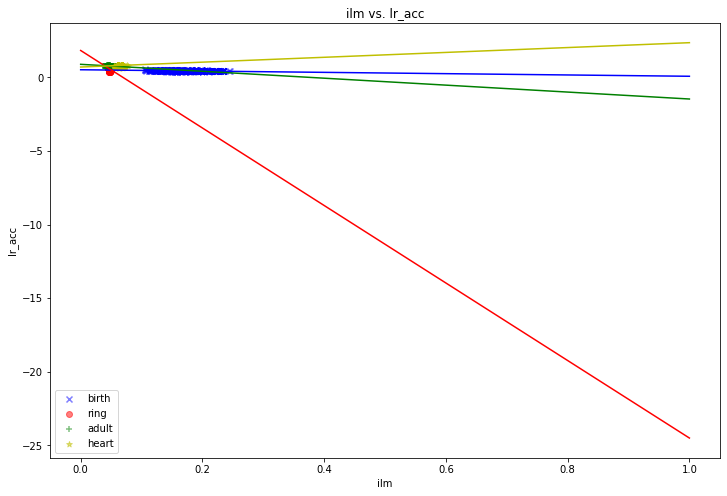

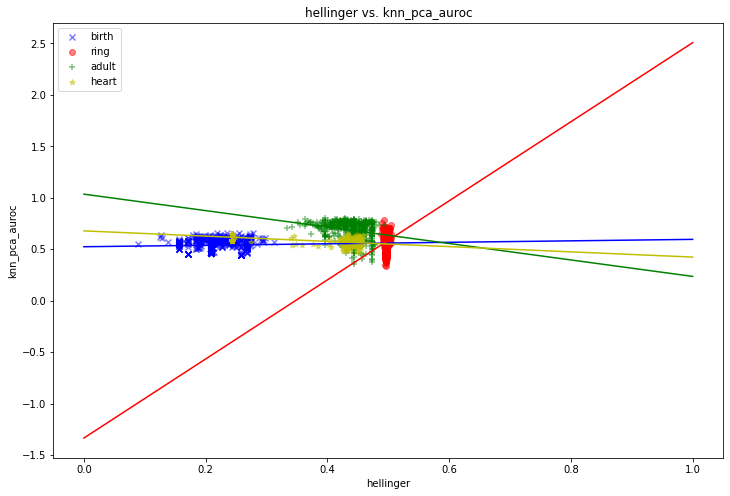

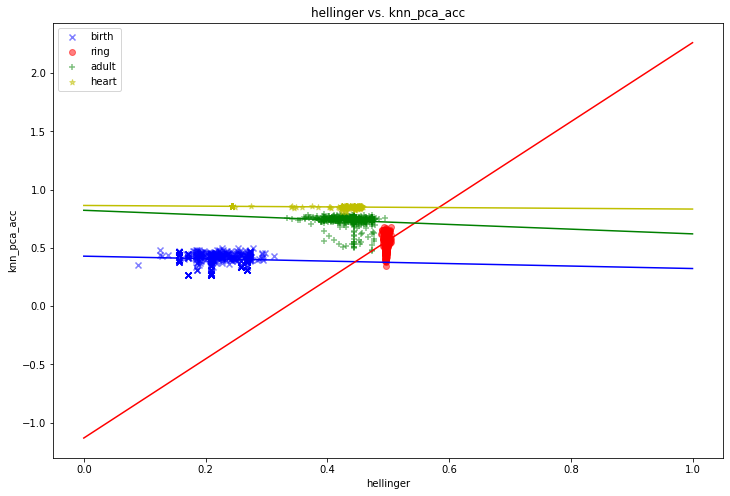

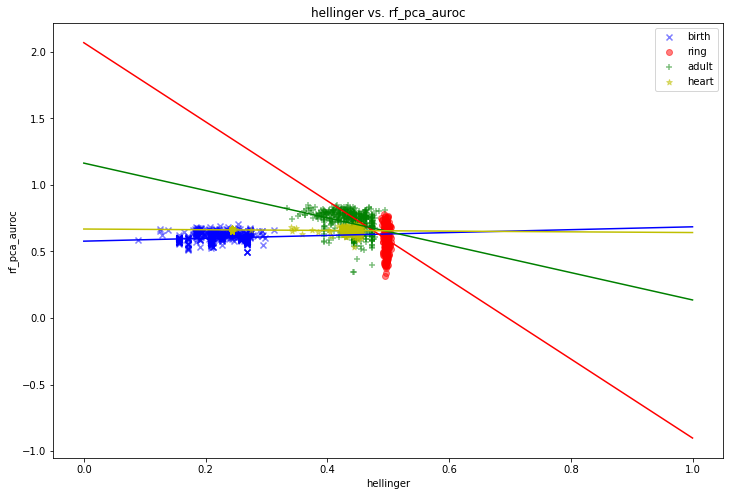

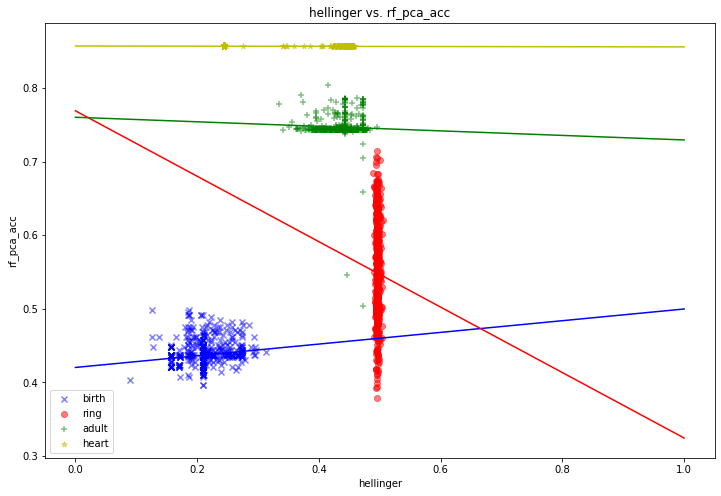

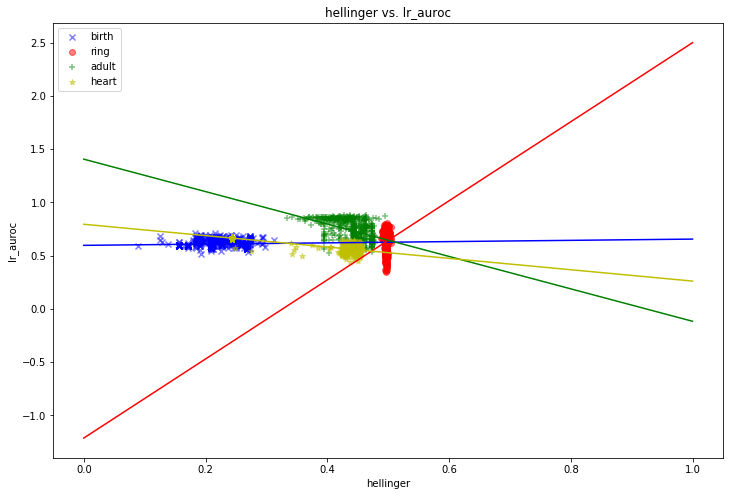

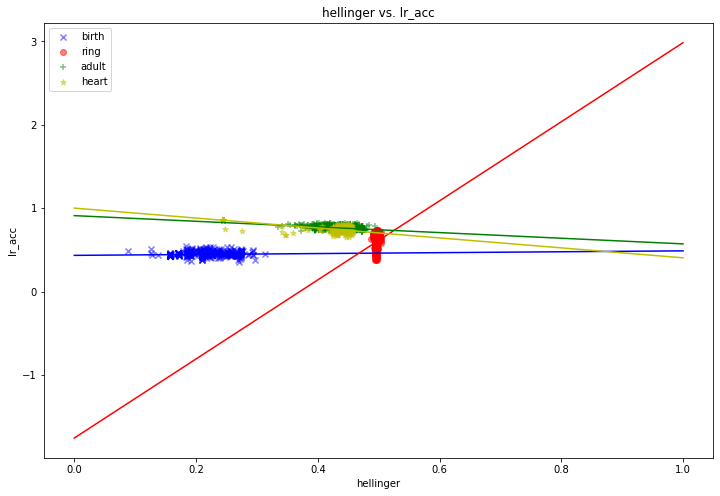

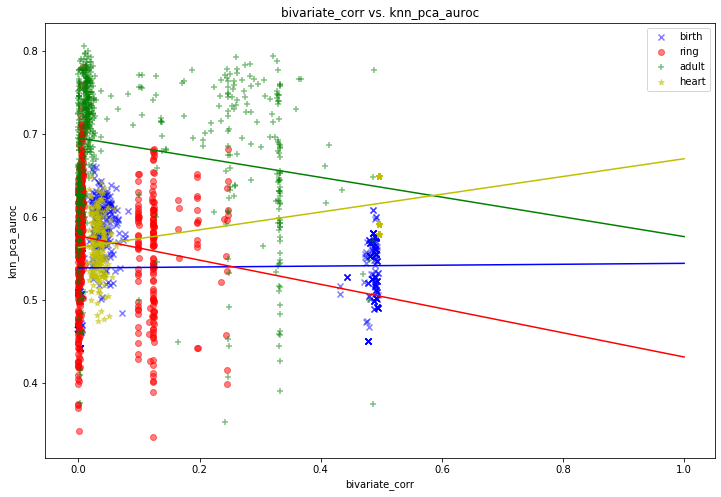

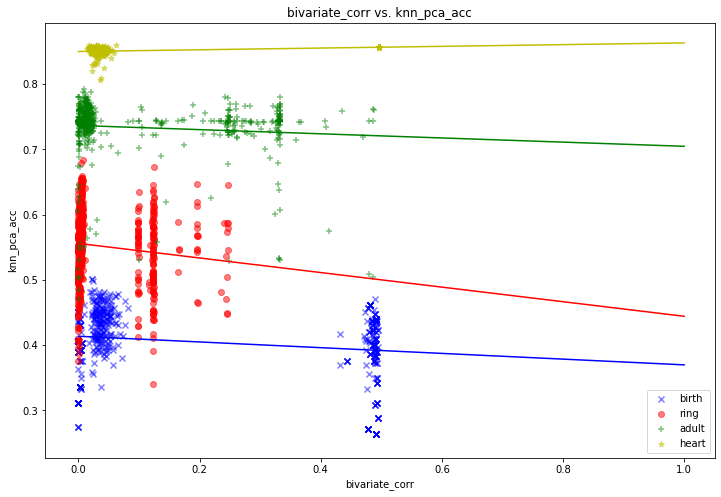

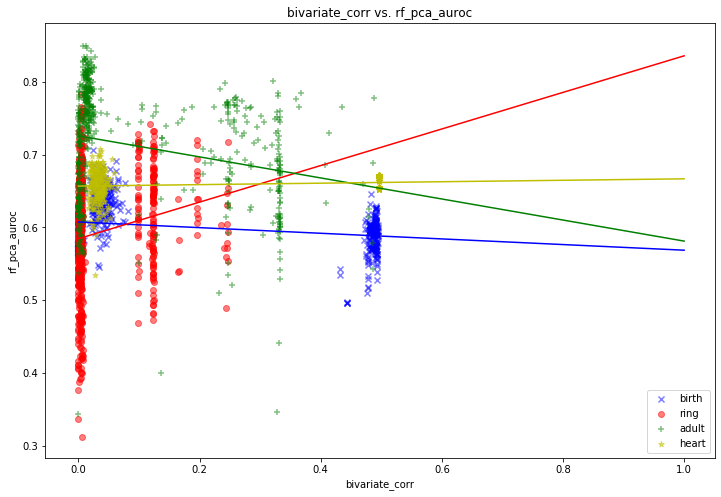

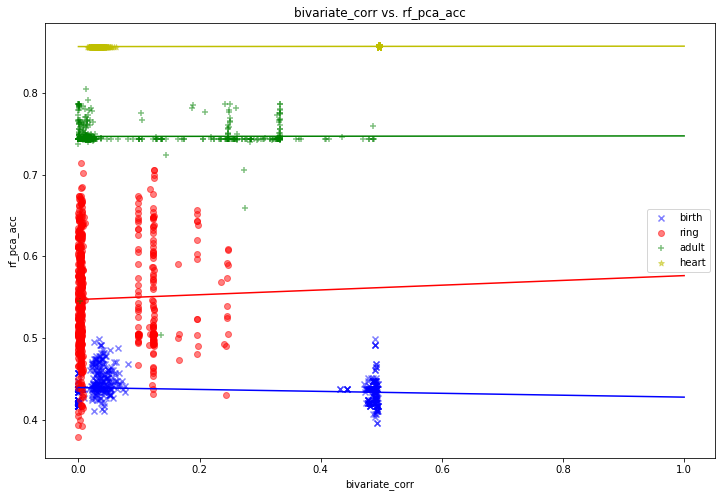

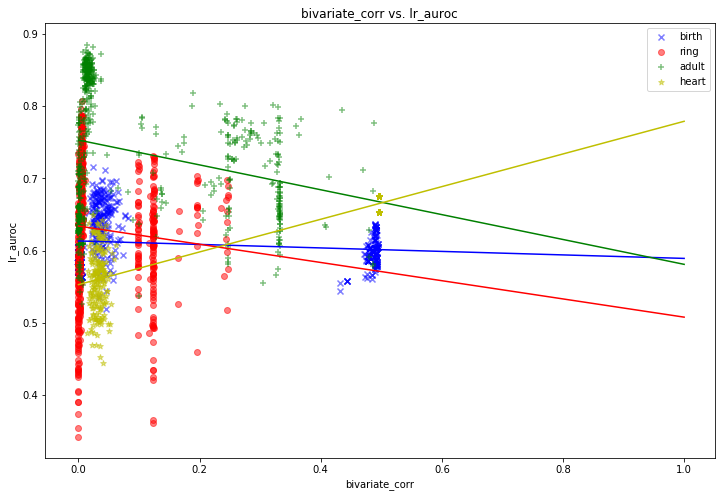

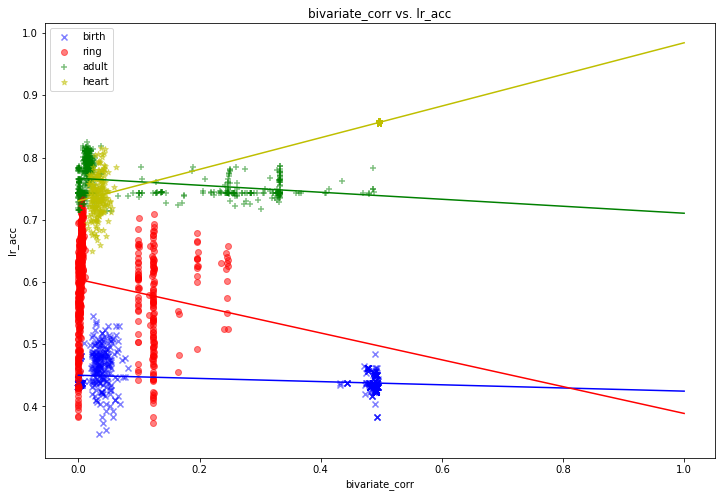

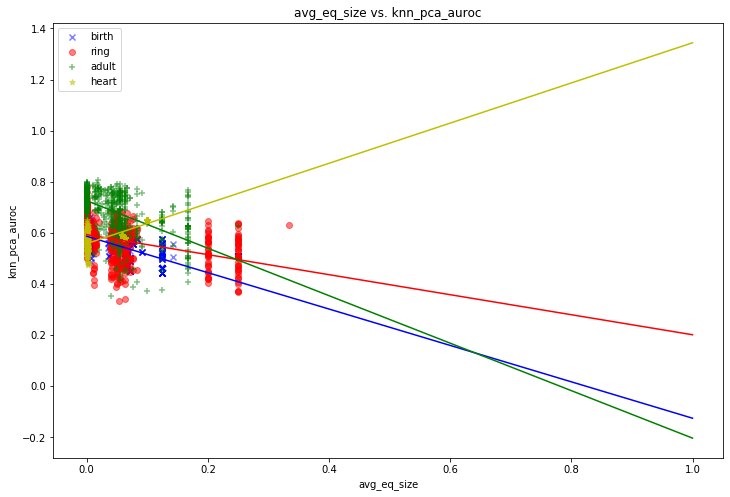

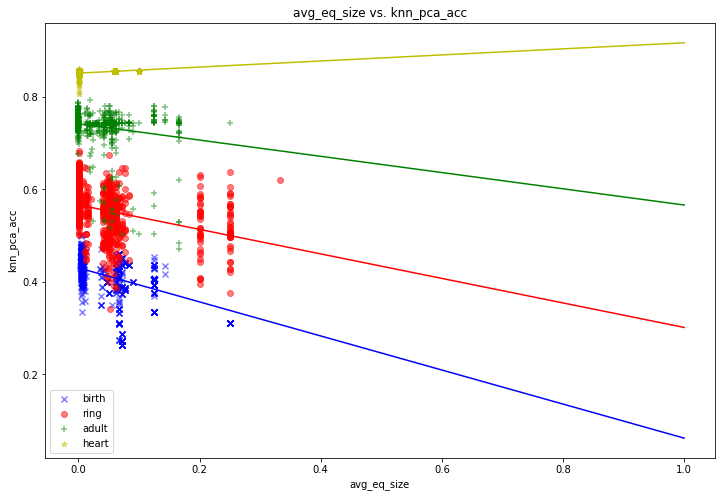

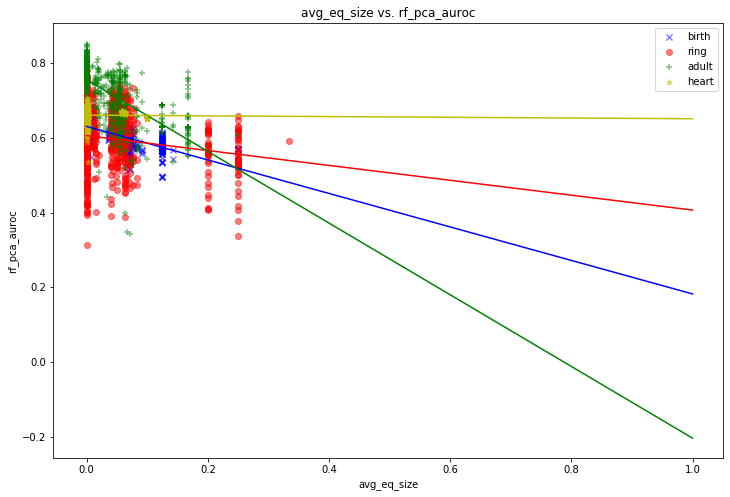

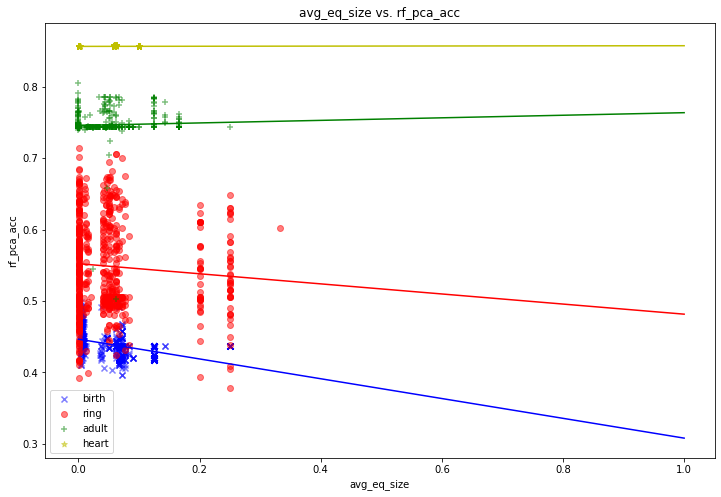

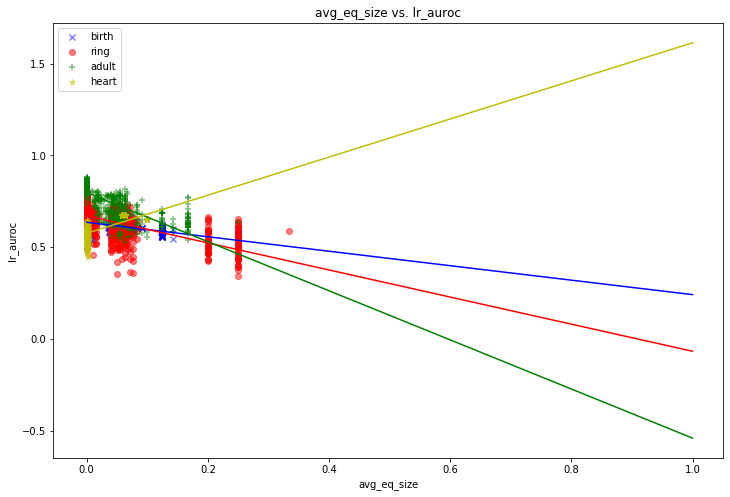

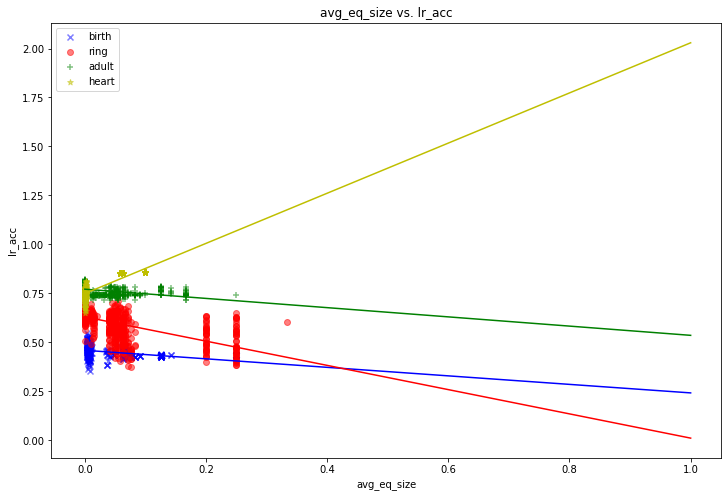

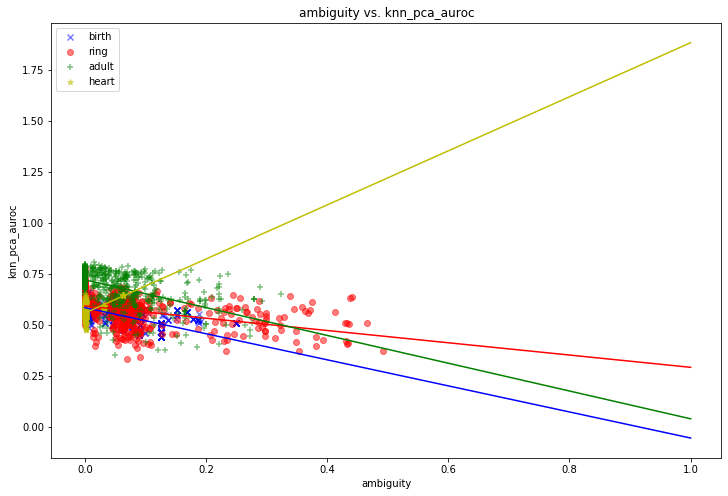

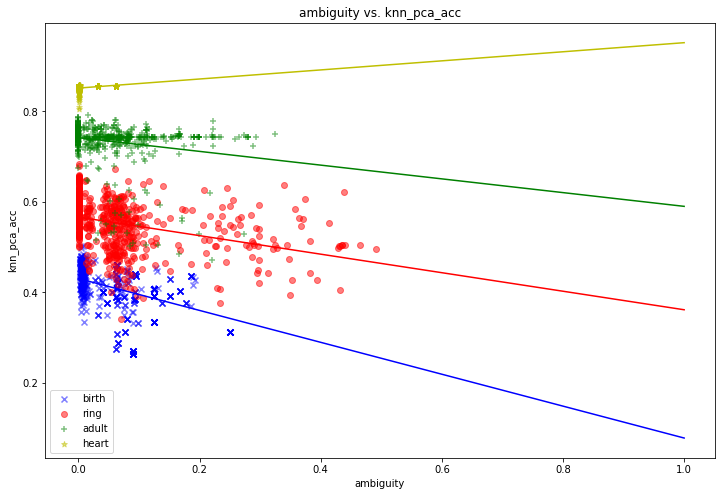

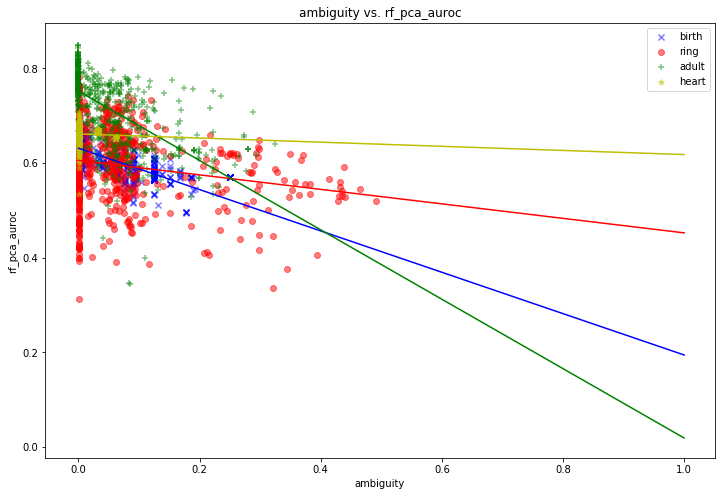

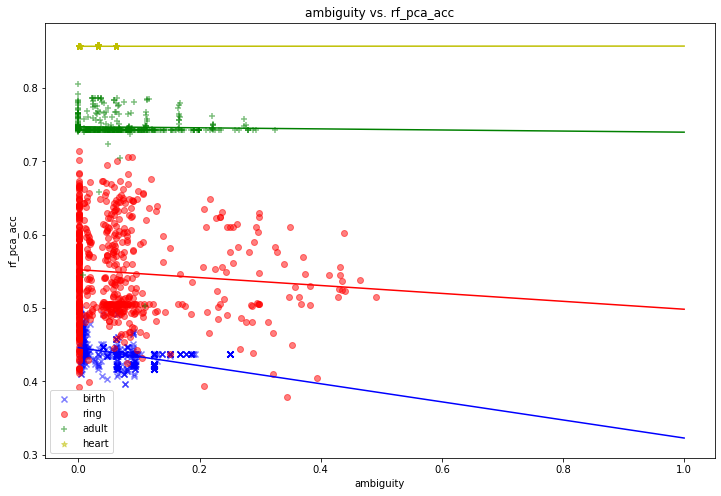

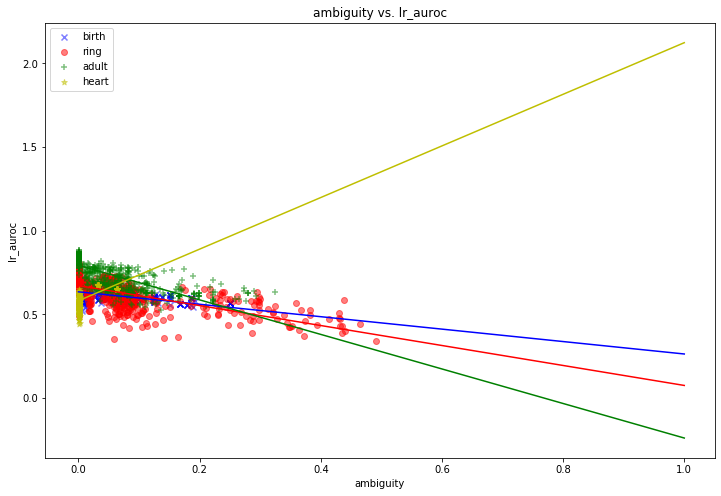

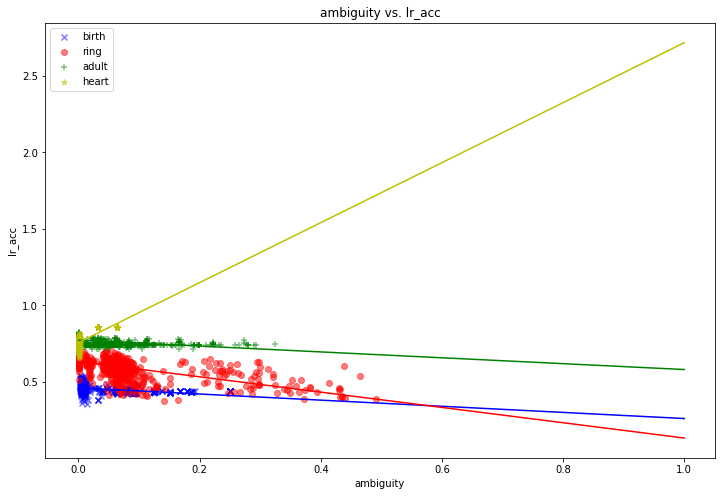

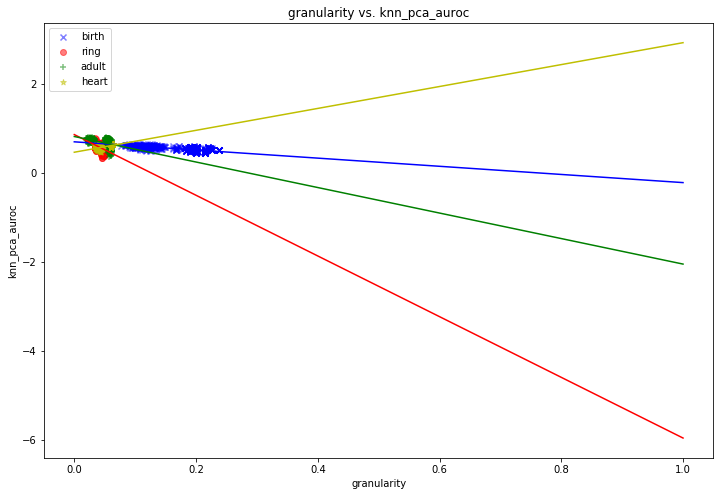

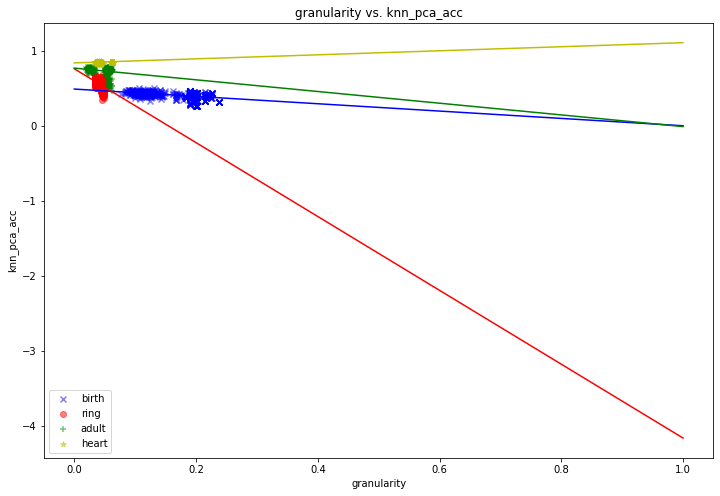

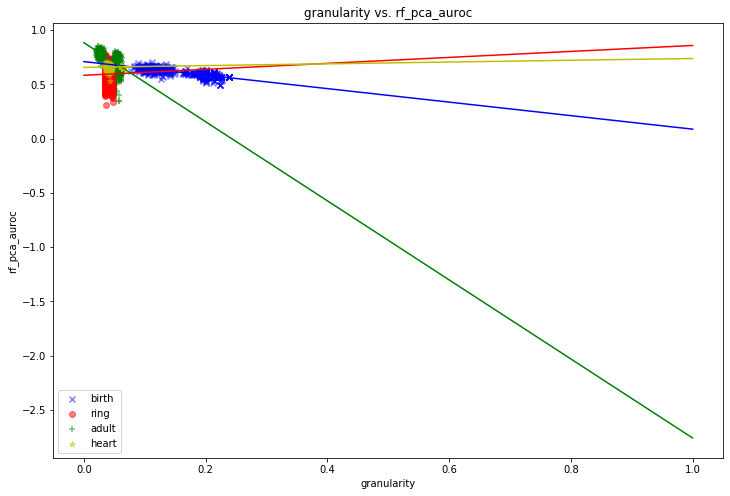

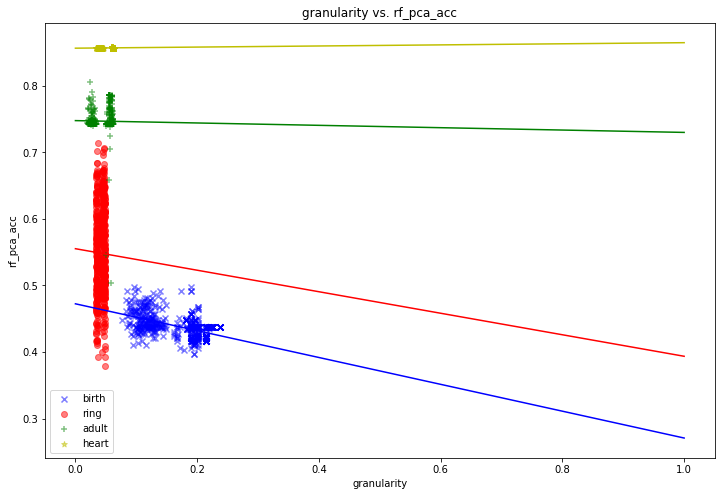

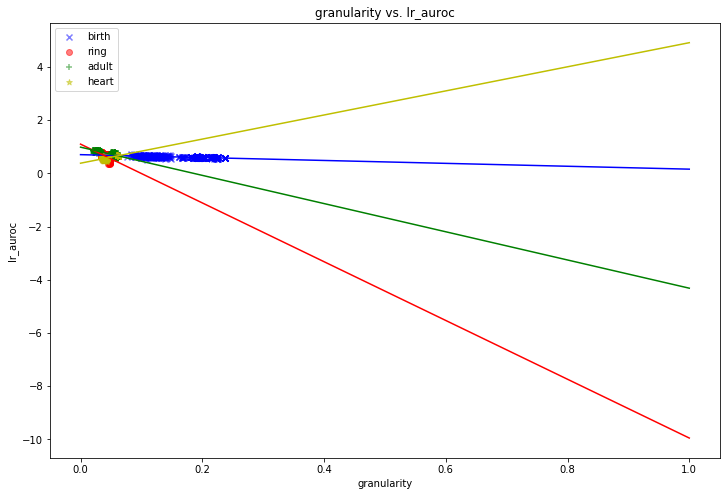

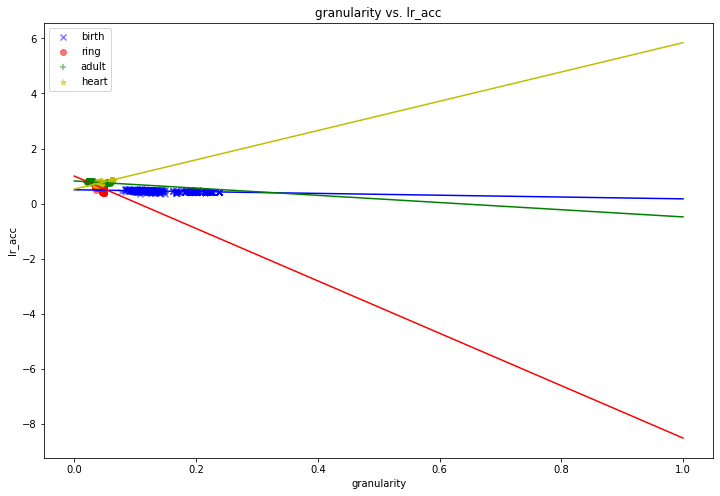

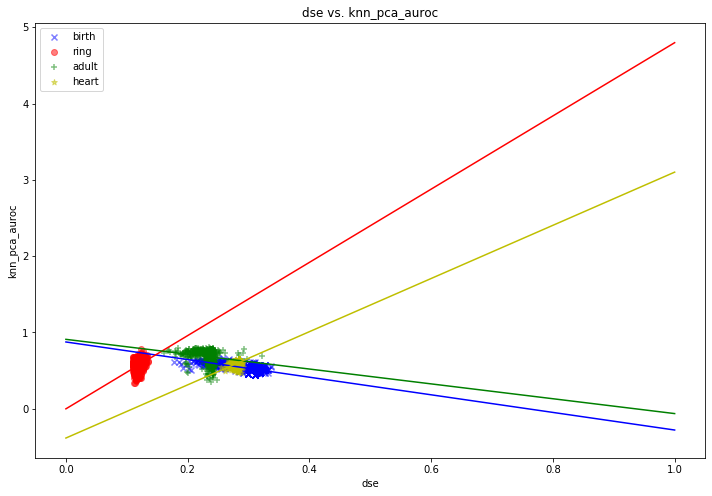

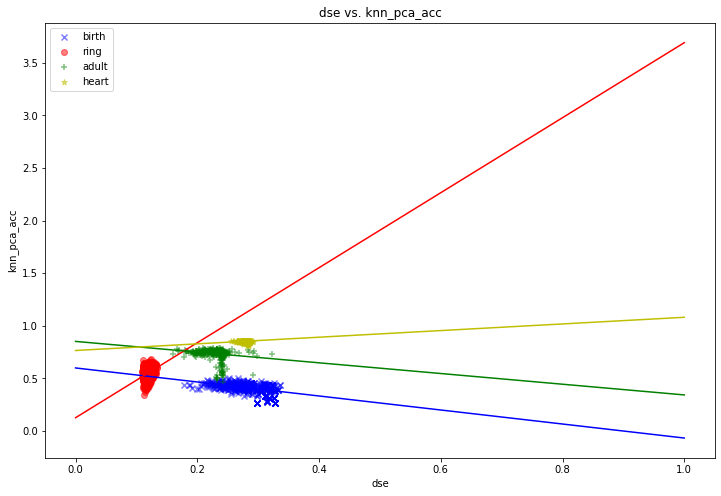

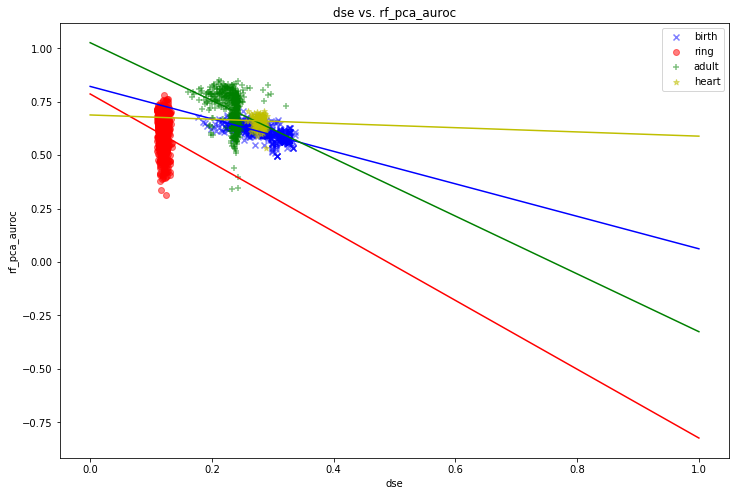

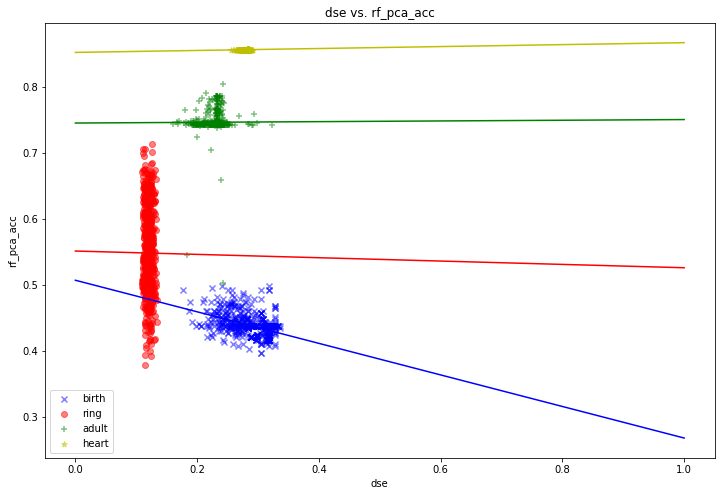

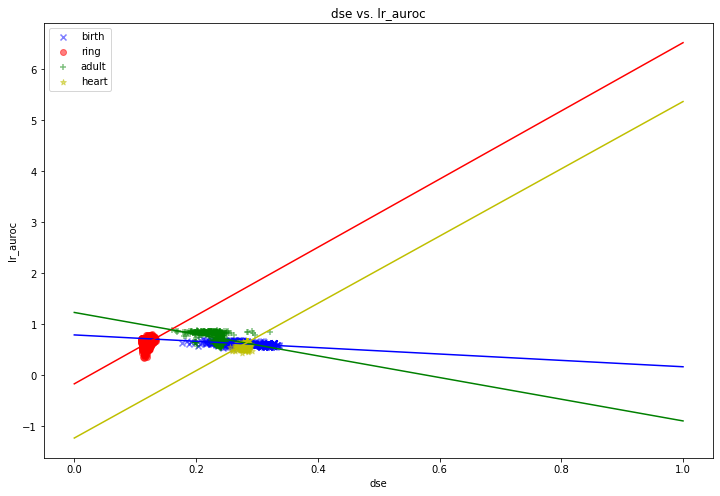

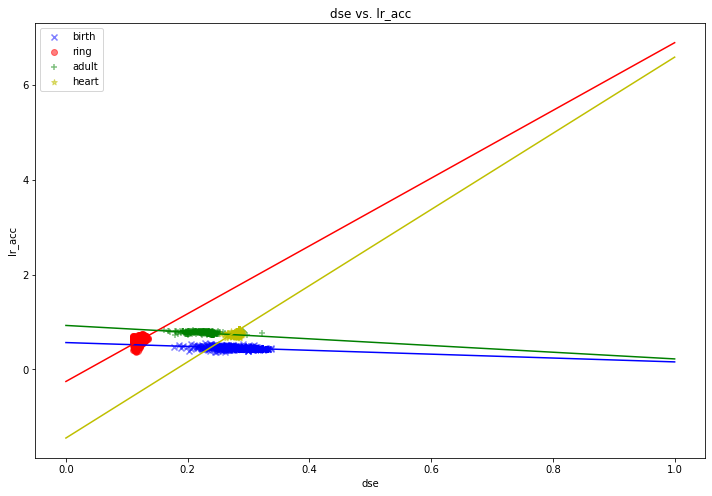

In [5]:
for m in metrics.columns[3:]:
    for target in accs.columns[3:]:
        plot_metric(m, target)

### Paper plots

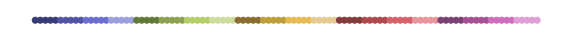

In [273]:
from matplotlib import cm

colormap = cm.get_cmap('tab20b')

x = np.linspace(0,1,100)
plt.figure(figsize=(10,.5))
plt.scatter(x, np.zeros(x.shape), c=colormap(x)); plt.axis('off');

In [274]:
plot_info = [(birth, birth_accs, colormap(0), ".", "BIRTH"),
            (ring, ring_accs, colormap(0.61), ".", "RING"),
            (adult, adult_accs, colormap(0.41), ".", "ADULT"),
            (heart, heart_accs, colormap(0.21), ".", "HEART")]

def niceplot_metric(metric, accuracy, with_x_label=False, with_y_label=False, with_legend=False):
    xmin = 1  # min = biggest possible value to start with
    xmax = 0
    ymin = 1
    ymax = 0
    # I'm experimenting with a flipped graph -- let's see how it goes. (x,y) = (y,x)
    for metric_df, accuracy_df, color, mark, label in plot_info:
        # Scatter plot of the data.
        plt.scatter(accuracy_df[accuracy], metric_df[metric], c=color, marker=mark, alpha=0.5, label=label)
    
    # This is a separate plot, because we want the lines to overwrite everything.
    for metric_df, accuracy_df, color, mark, label in plot_info:
        # Compute a linear regression for this parameter.
        X = metric_df[metric].values.reshape(-1,1)
        y = accuracy_df[accuracy]
        lin_reg = LinearRegression().fit(X, y)
        
        # Display the result as a line.
        margin = 0.1
        x=[[max(0, X.min()-margin)],[min(1, X.max()+margin)]]
        plt.plot(lin_reg.predict(x), x, '--', c=color, alpha=1)
        
        # Update the axis size to adjust display region.
        xmin = min(xmin, X.min())
        xmax = max(xmax, X.max())
        ymin = min(ymin, y.min())
        ymax = max(ymax, y.max())

    # Set a title?
    # no  # plt.title(f"{metric} vs. {accuracy}")
    if with_y_label:
        plt.ylabel(metric, fontsize=20, fontname='Arial')
    else:
        plt.tick_params(axis='y', left=False, labelleft=False)
    if with_x_label:
        plt.xlabel(accuracy, fontsize=20, fontname='Arial')
    else:
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
    # Round to 0.1.
    xmin = np.floor(xmin*10)/10
    xmax = np.ceil(xmax*10)/10
    ymin = np.floor(ymin*10)/10
    ymax = np.ceil(ymax*10)/10
    plt.ylim([max(0, xmin), min(1, xmax)])
    plt.xlim([max(0, ymin), min(1, ymax)])
    # Set the legend nicely.
    # plt.legend()

# plot datasets separately

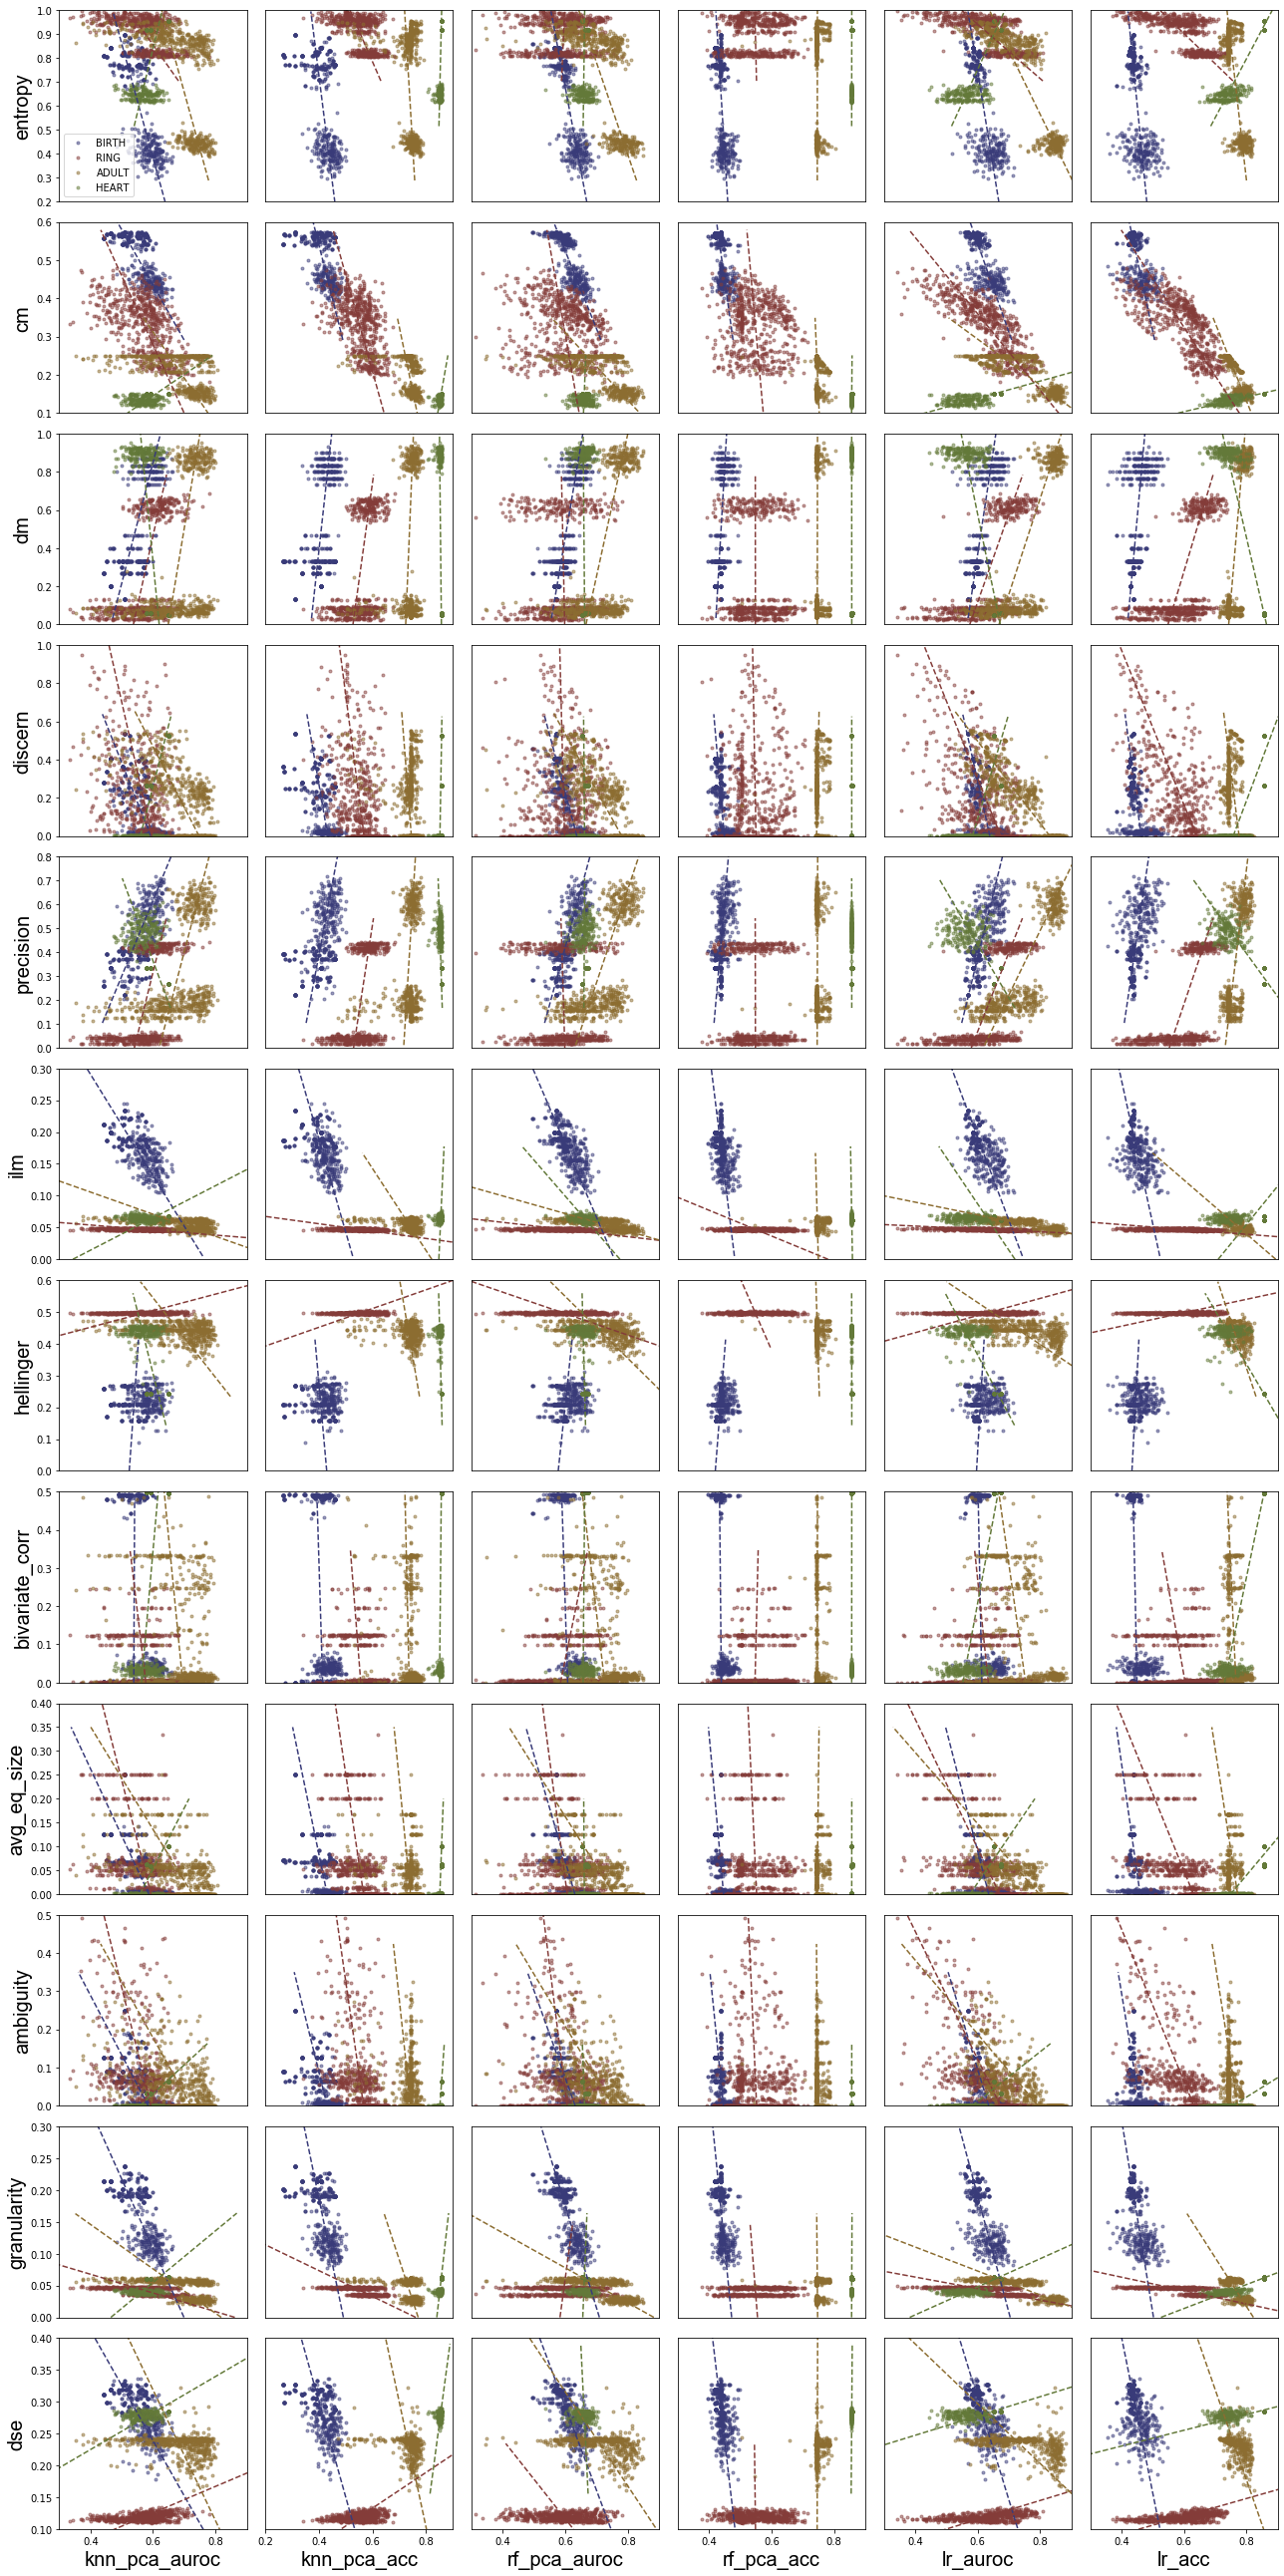

In [276]:
n_metrics = len(metrics.columns) - 3
n_accs = len(accs.columns) - 3

cell_size = 3
plt.figure(figsize=(n_accs*cell_size, n_metrics*cell_size))

for i, accuracy in enumerate(accs.columns[3:]):
    for j, metric in enumerate(metrics.columns[3:]):
        plt.subplot(n_metrics, n_accs, j*n_accs+i+1)
        niceplot_metric(metric, accuracy, with_x_label=(j==n_metrics-1), with_y_label=(i==0))
        if i==0 and j==0:
            plt.legend()
plt.tight_layout()

plt.savefig('metrics-vs-accs.png')

## idea for a better plot: sort by prediction power of metrics

In [277]:
label_to_dfs = {
    'BIRTH': (birth, birth_accs),
    'RING': (ring, ring_accs),
    'ADULT': (adult, adult_accs),
    'HEART': (heart, heart_accs),
}

In [303]:
def quality(metric, accuracy, dataset):
    """Quality of a metric as measure by the accuracy."""
    metrics_df, accs_df = label_to_dfs[dataset]
    x = metrics_df[metric].values
    y = accs_df[accuracy]
    # Return relative RMSE (percent of variance explained)?
#     lr = LinearRegression().fit(x.reshape(-1, 1), y)
#     y_pred = lr.predict(x.reshape(-1, 1))
#     return 1 - (skmet.mean_squared_error(y, y_pred) / np.var(y))
    rank_x = np.argsort(np.argsort(x))
    rank_y = np.argsort(np.argsort(y))
    return abs(scipy.stats.spearmanr(rank_x, rank_y)[0])

In [304]:
quality('dse', 'lr_acc', 'HEART')

0.6544667624076733

In [305]:
ds = 'HEART'

accuracy = 'lr_acc'

mets = metrics.columns[3:]

q = np.array([quality(m, accuracy, ds) for m in mets])

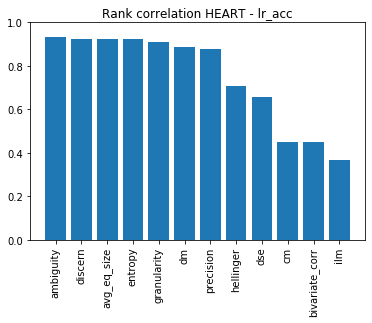

In [312]:
index = np.argsort(q)[::-1]

x = np.arange(1, len(mets)+1)
plt.bar(x, q[index])
plt.xticks(x, labels=[mets[i] for i in index], rotation=90);
plt.title(f'Rank correlation {ds} - {accuracy}')
plt.ylim([0, 1]);

# Mega Metric Scatters
Je plot ici des scatter plots des 4 datasets et de leur mega metric obtenus avec les mesures d'utilites differentes.

In [200]:
def mega_scatter(target):
    plt.figure(figsize=(12,8))
    for dataset, acc_set, col, mark, label in plot_info:
        X_test = pd.read_csv(f"{label.lower()}_randoms/metrics_testset.csv")
        X_test = X_test.drop(["lr_acc", "algo", "no", "auroc"], axis=1)

        y_test = pd.read_csv(f"{label.lower()}_randoms/accuracies_testset.csv")
        y_test = y_test[target]

        model = pickle.load(open(f"autosklearn_models/automl_{label.lower()}_randoms_{target}.pkl", "rb"))
        pred_y = model.predict(X_test)
        plt.scatter(pred_y, y_test, c=col, marker=mark, alpha=0.5, label=label)
        
        lin_reg = LinearRegression().fit(pred_y.reshape(-1,1), y_test)
        x=[[0],[1]]
        plt.plot(x, lin_reg.predict(x), c=col, alpha=0.5)

        plt.title(f"Mega Metric for {target} as utility measure")
        plt.xlabel("Predicted Score")
        plt.ylabel("Actual Score")
        plt.legend()
    plt.show()
    

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomTreesEmbedding from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator FeatureAgglomeration from version 0.22.2.post1 when usi

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomTreesEmbedding from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Nystroem from version 0.22.2.post1 when using 

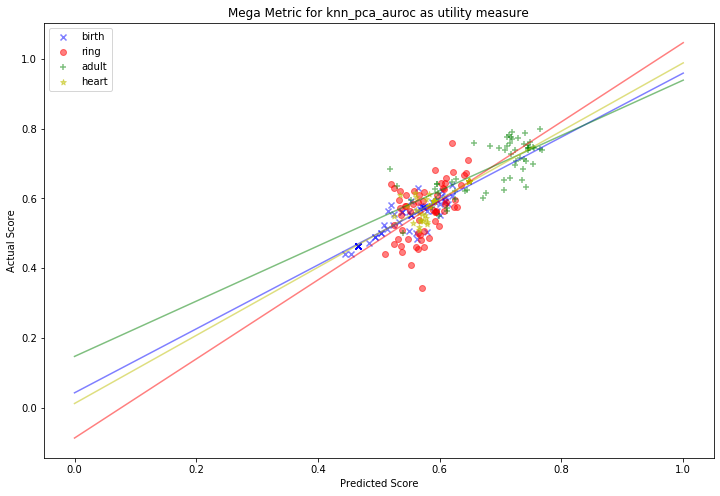

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SelectPercentile from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KernelCenterer from version 0.22.2.post1 when using version 

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Normalizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator FastICA from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator FeatureAgglomeration from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Normalizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator FeatureAgglomeration from version 0.22.2.post1 when using v

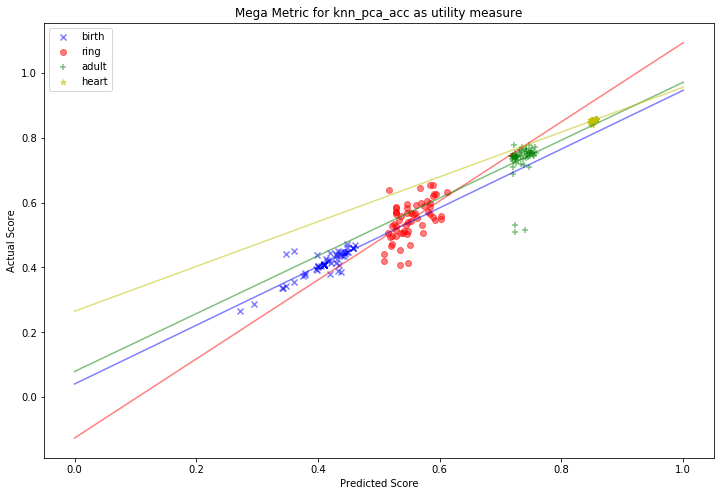

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.22.2.post1 when using v

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RBFSampler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SelectPercentile from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Nystroem from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator _BinMapper from version 0.22.2.post1 when using version 0.22.1. This

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Normalizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KernelCenterer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KernelPCA from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.22.2.post1 when using version 0.2

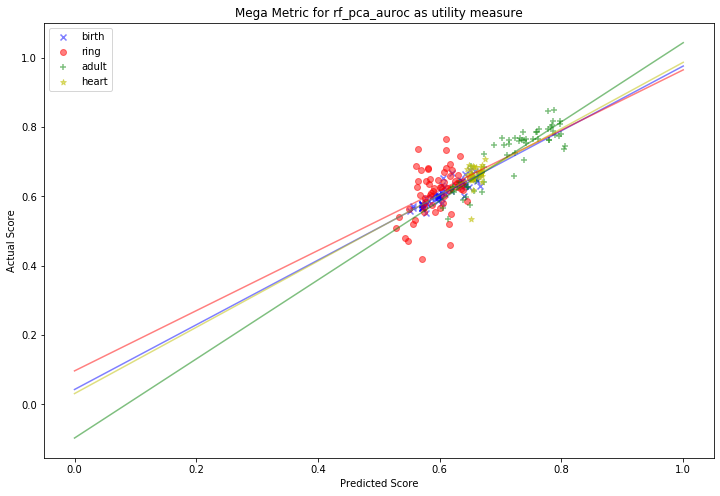

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SelectPercentile from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVR from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator FastICA from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.22.2.post1 when

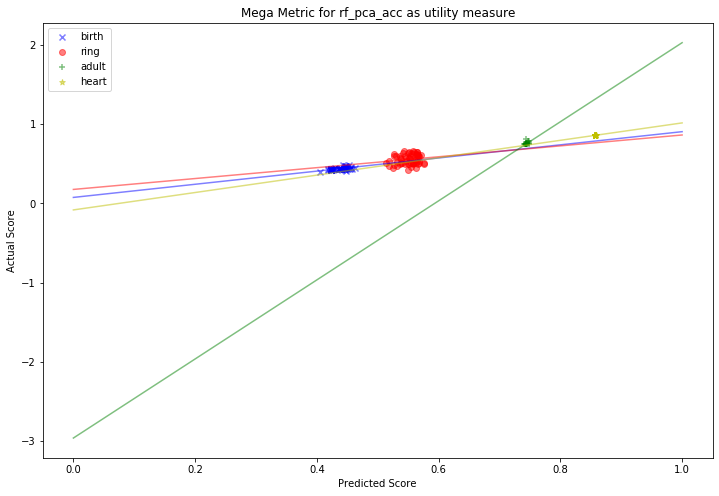

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Nystroem from version 0.22.2.post1 when using versi

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ExtraTreesRegressor from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SelectFromModel from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using ver

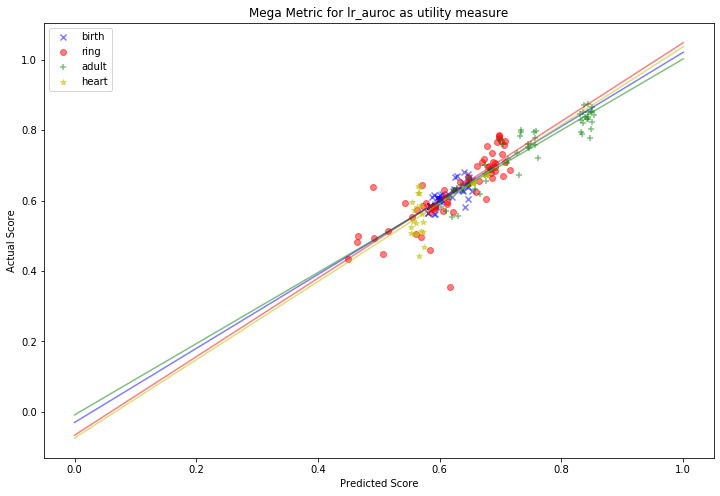

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Normalizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ExtraTreeRegressor from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomTreesEmbedding from version 0.22.2.post1 when using v

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator AdaBoostRegressor from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ARDRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.22.2.post1 whe

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Nystroem from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


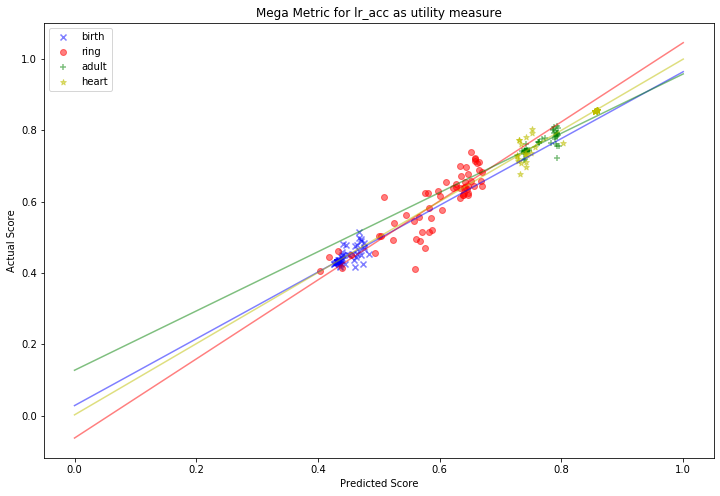

In [7]:
for target in accs.columns[3:]:
    mega_scatter(target)

### Paper plots

In [207]:
# Collect values of the meta-metric from disk once and for all.

megametric_vs_task = {}

for target in accs.columns[3:]:
    for dataset, acc_set, col, mark, label in plot_info:
        X_test = pd.read_csv(f"{label.lower()}_randoms/metrics_testset.csv")
        X_test = X_test.drop(["lr_acc", "algo", "no", "auroc"], axis=1)

        y_test = pd.read_csv(f"{label.lower()}_randoms/accuracies_testset.csv")
        y_test = y_test[target]

        model = pickle.load(open(f"autosklearn_models/automl_{label.lower()}_randoms_{target}.pkl", "rb"))
        pred_y = model.predict(X_test)
        
        megametric_vs_task[(target, label)] = (y_test, pred_y)

In [231]:
def niceplot_metric(accuracy, the_label, with_title=False, with_x_label=False, with_y_label=False):
    xmin = 1  # min = biggest possible value to start with
    xmax = 0
    ymin = 1
    ymax = 0
    
    plt.plot([0,1], [0,1], 'k--', alpha=.2)  # Put the benchmark
    
    # I'm experimenting with a flipped graph -- let's see how it goes. (x,y) = (y,x)
    for metric_df, accuracy_df, color, mark, label in plot_info:
        
        if label == the_label: # v dirty hack
            y_test, y_pred = megametric_vs_task[(accuracy, label)]

            # Scatter plot of the data.
            plt.scatter(y_pred, y_test, c=color, marker=mark, alpha=1, label=label)

            # Update the axis size to adjust display region.
            xmin = min(xmin, y_pred.min())
            xmax = max(xmax, y_pred.max())
            ymin = min(ymin, y_test.min())
            ymax = max(ymax, y_test.max())

    # Set a title?
    # no  # plt.title(f"{metric} vs. {accuracy}")
    if with_y_label:
        plt.ylabel(f'{accuracy} (real)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='y', left=False, labelleft=False)
    if with_x_label:
        plt.xlabel(f'(predicted)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='x', bottom=False, labelbottom=False)
    if with_title:
        plt.title(the_label, fontsize=20, fontname='Arial')
    # Round to 0.1.
    xmin = np.floor(xmin*10)/10
    xmax = np.ceil(xmax*10)/10
    ymin = np.floor(ymin*10)/10
    ymax = np.ceil(ymax*10)/10
    plt.ylim([max(0, xmin), min(1, xmax)])
    plt.xlim([max(0, ymin), min(1, ymax)])
    # Set the legend nicely.
    # plt.legend()

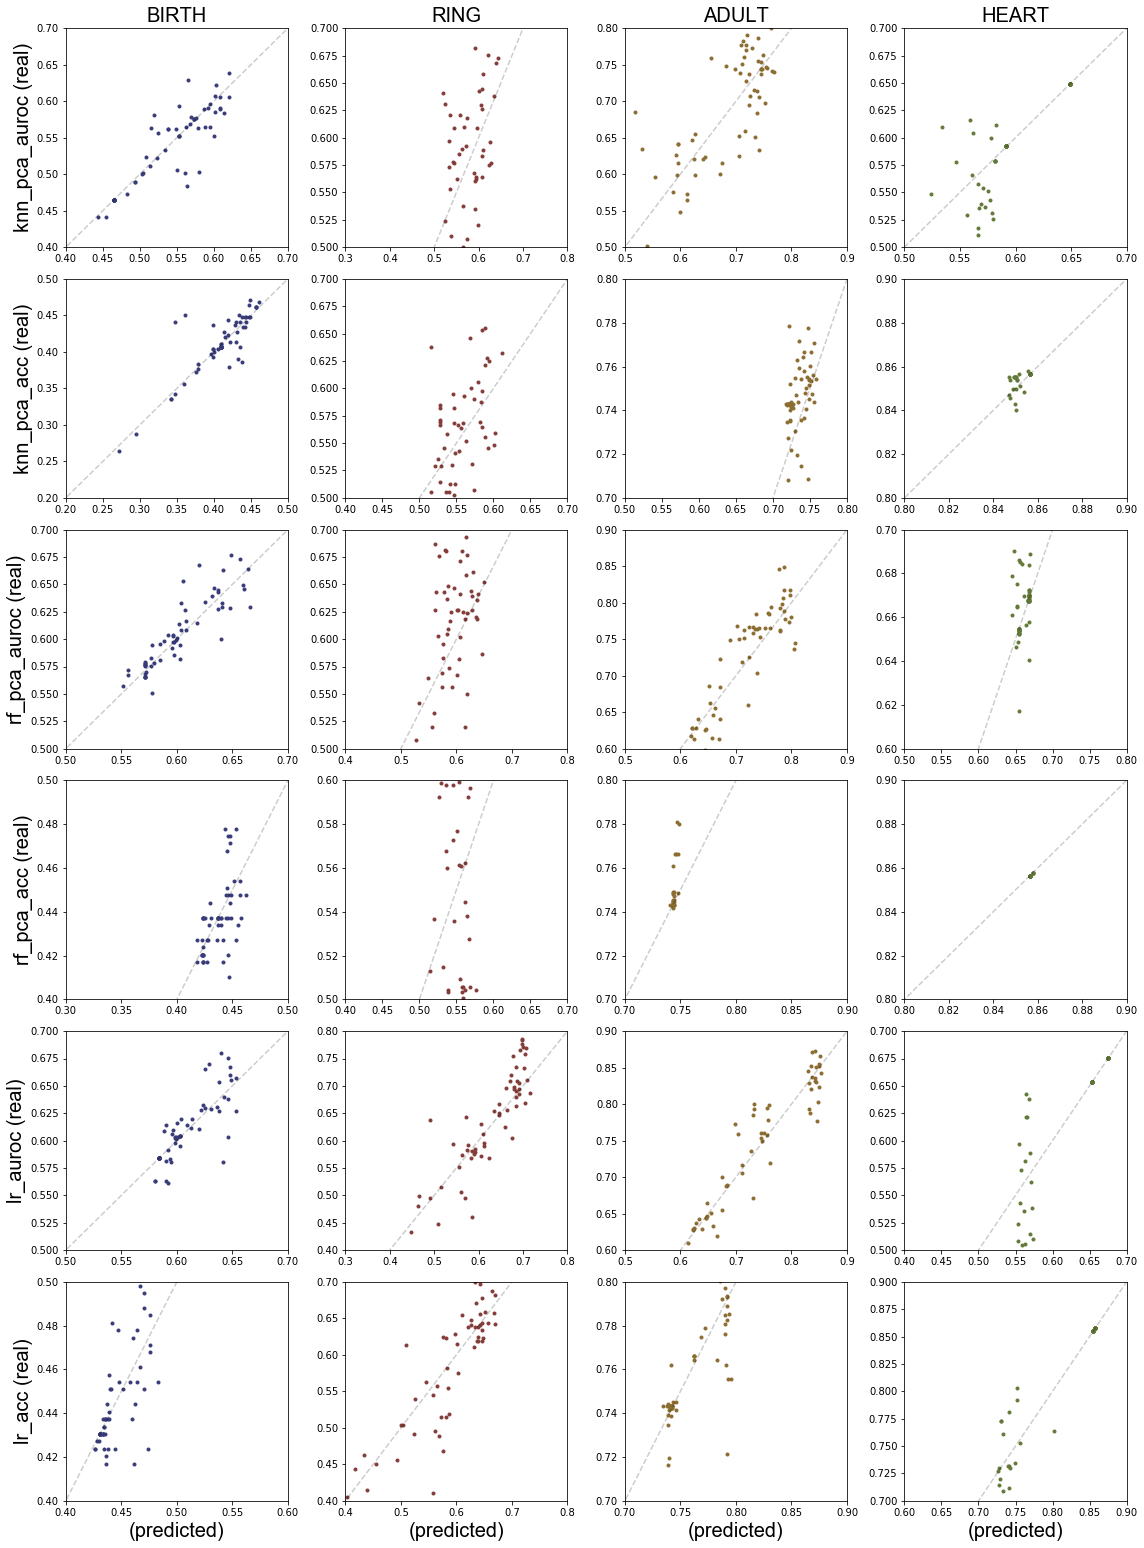

In [232]:
cellsize = 4

plt.figure(figsize=(4*cellsize, n_accs*cellsize*0.9))

i = 1
for target in accs.columns[3:]:
    for _,_,_,_,label in plot_info:
        plt.subplot(n_accs, 4, i)
        niceplot_metric(target, label, with_x_label=(i>4*(n_accs-1)), with_y_label=((i%4)==1), with_title=(i<=4))
        i += 1
plt.tight_layout()

plt.savefig('megametrics-vs-accs.png')

In [236]:
for target in accs.columns[3:]:
    for _,_,_,_,label in plot_info:
        y_test, y_pred = megametric_vs_task[(target, label)]
        err = skmet.mean_squared_error(y_test, y_pred)
        err0 = skmet.mean_squared_error(y_test, np.full(y_test.shape, y_test.mean()))
        print(target, label, np.sqrt(err/err0))

knn_pca_auroc BIRTH 0.4711346922507738
knn_pca_auroc RING 0.87513074382452
knn_pca_auroc ADULT 0.7057817293730971
knn_pca_auroc HEART 0.5471070095501802
knn_pca_acc BIRTH 0.5420894128578764
knn_pca_acc RING 0.8341038764448885
knn_pca_acc ADULT 0.9781768123156019
knn_pca_acc HEART 0.835782099565339
rf_pca_auroc BIRTH 0.48041321627837197
rf_pca_auroc RING 0.9669301566416431
rf_pca_auroc ADULT 0.4644456236089921
rf_pca_auroc HEART 0.9406812487373479
rf_pca_acc BIRTH 0.8026272965442376
rf_pca_acc RING 0.989956122098261
rf_pca_acc ADULT 1.0022894637347575
rf_pca_acc HEART 0.16712184690475915
lr_auroc BIRTH 0.5776935669111783
lr_auroc RING 0.588856422582036
lr_auroc ADULT 0.3457570296919731
lr_auroc HEART 0.5175411121843436
lr_acc BIRTH 0.7347730661333677
lr_acc RING 0.5095597855228758
lr_acc ADULT 0.6184162951382258
lr_acc HEART 0.308208203467133


# Use a Dataset's Mega Metrics on others?
Here, we try to predict a dataset's utility using the mega metric from another dataset. You'll see that it doesn't work. At all...

In [8]:
def cross_test(orig_label, target):
    plt.figure(figsize=(12,8))
    model = pickle.load(open(f"autosklearn_models/automl_{orig_label}_randoms_{target}.pkl", "rb"))
    
    for dataset, acc_set, col, mark, label in plot_info:
        if label != orig_label:

            X_test = pd.read_csv(f"{label}_randoms/metrics_testset.csv")
            X_test = X_test.drop(["lr_acc", "algo", "no", "auroc"], axis=1)

            y_test = pd.read_csv(f"{label}_randoms/accuracies_testset.csv")
            y_test = y_test[target]


            pred_y = model.predict(X_test)
            plt.scatter(pred_y, y_test, c=col, marker=mark, alpha=0.5, label=label)

            lin_reg = LinearRegression().fit(pred_y.reshape(-1,1), y_test)
            x=[[0],[1]]
            plt.plot(x, lin_reg.predict(x), c=col, alpha=0.5)

            plt.title(f"{orig_label} Mega Metric for {target} on other datasets")
            plt.xlabel("Predicted Score")
            plt.ylabel("Actual Score")
            plt.legend()
    plt.show()

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

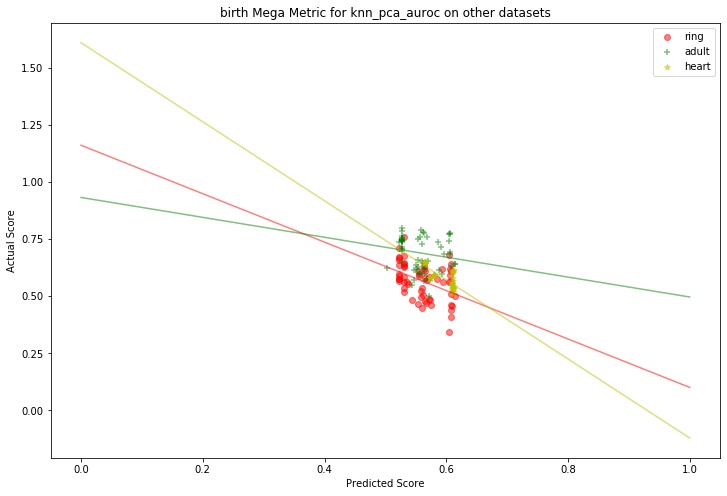

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using

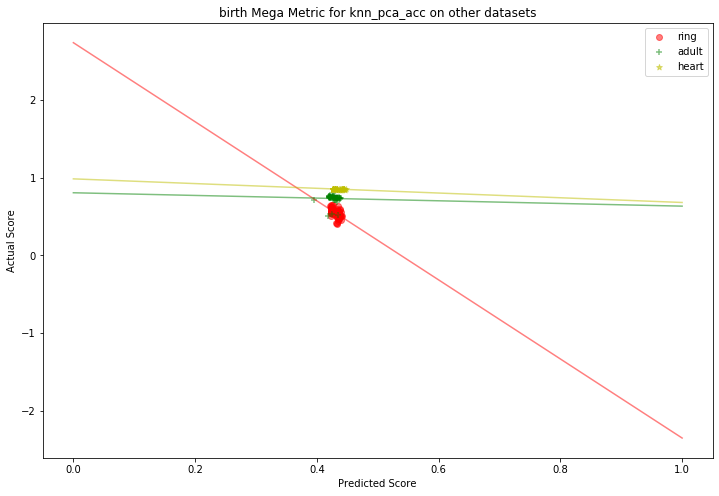

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.22.2.post1 when using v

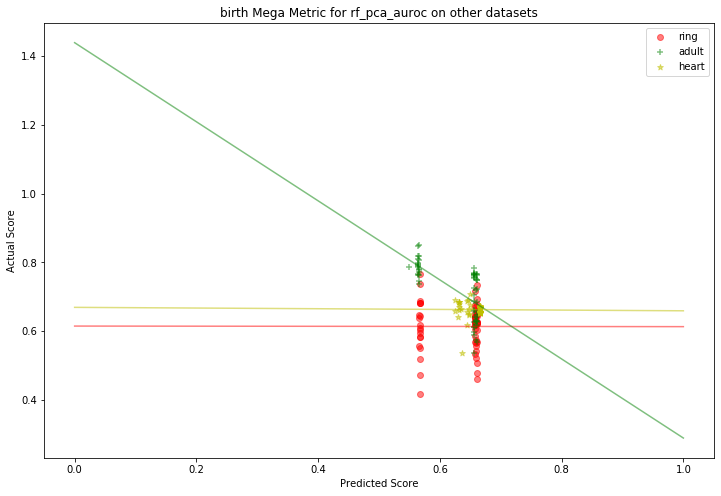

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

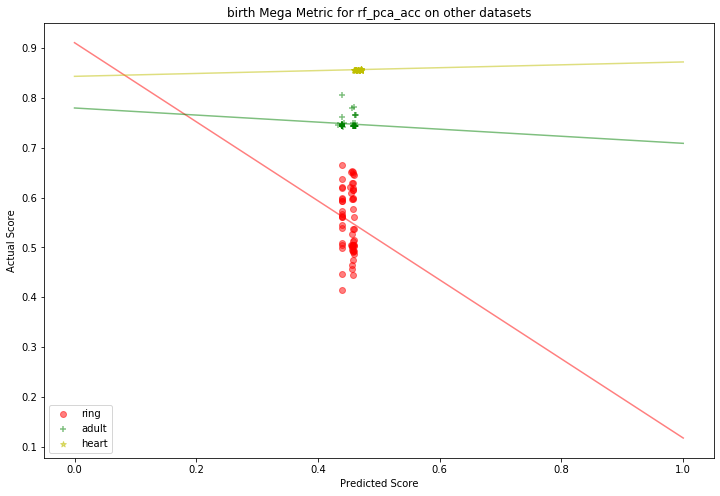

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using

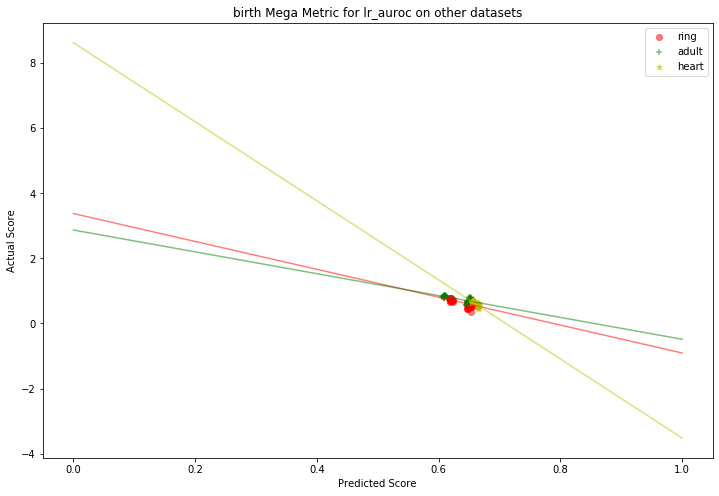

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

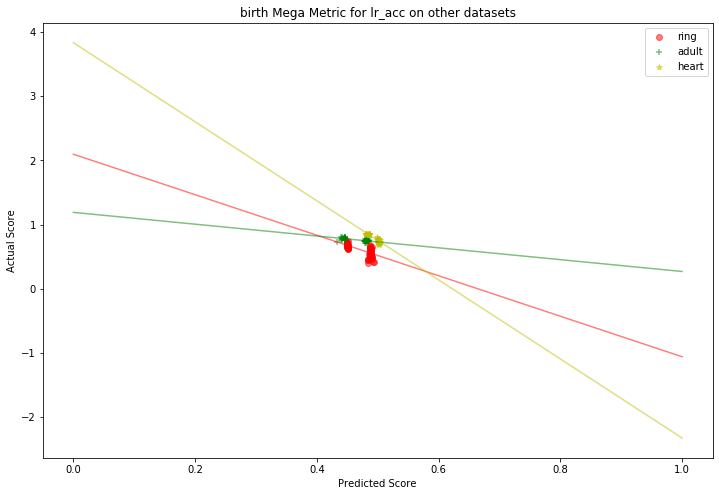

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

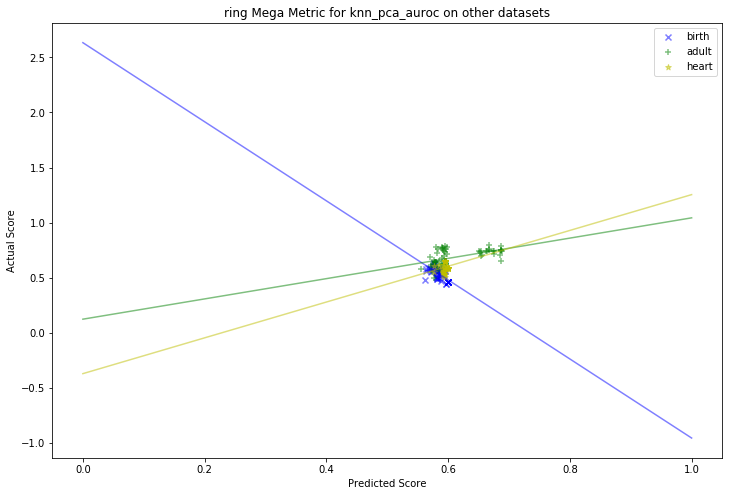

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Normalizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 

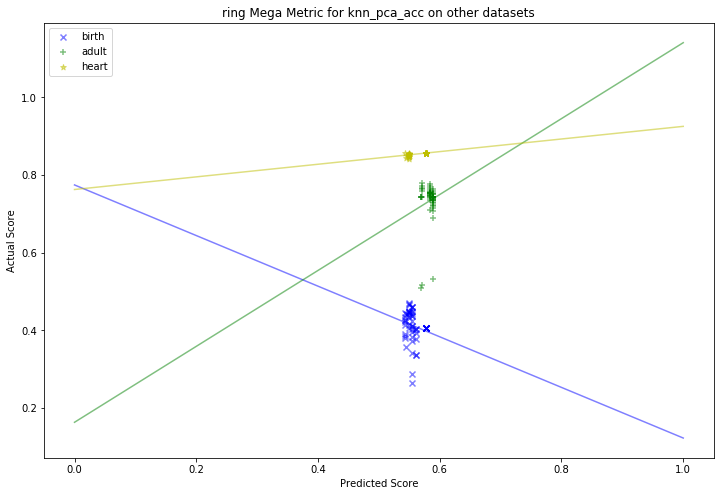

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

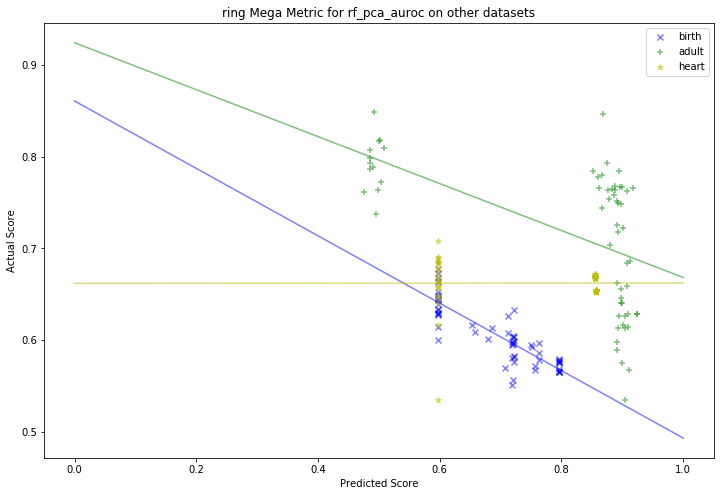

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Normalizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 

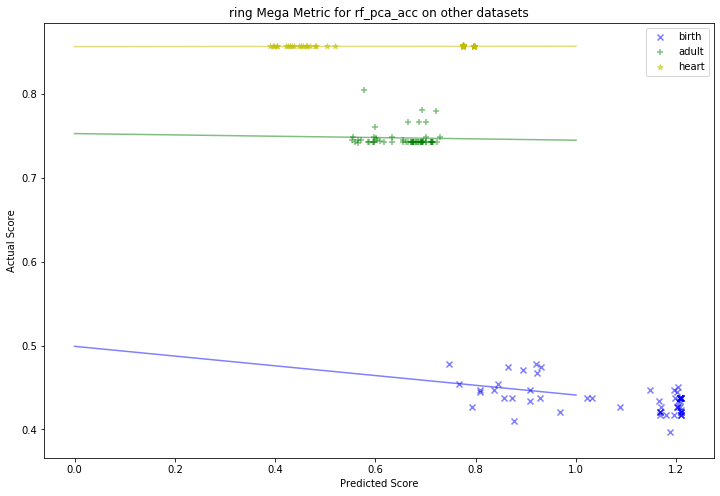

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

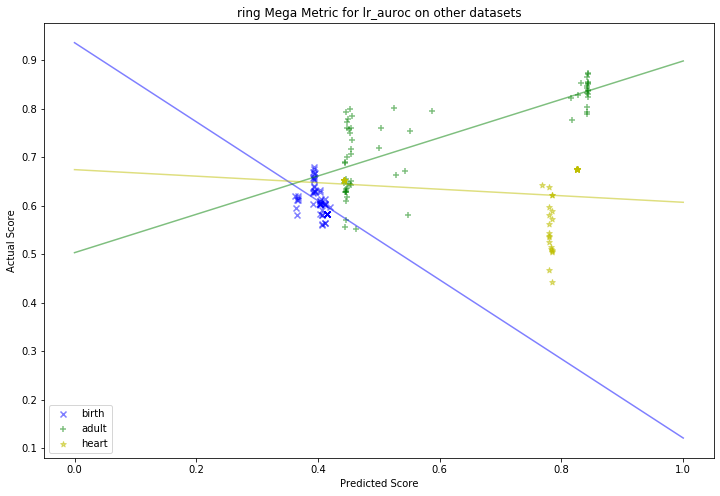

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

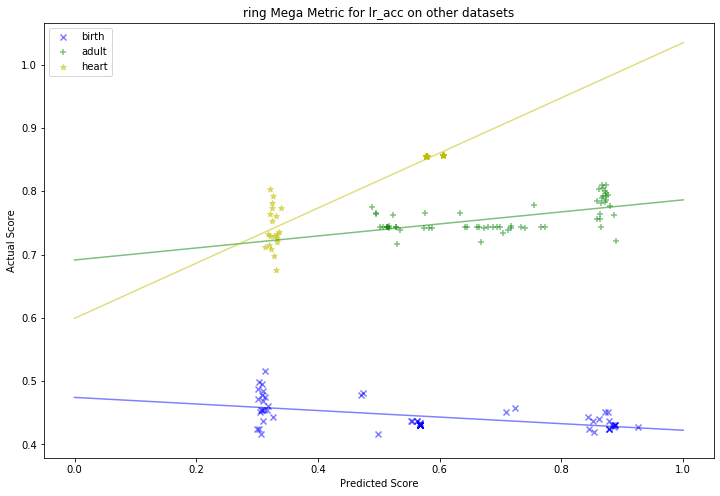

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.22.2.post1 when using v

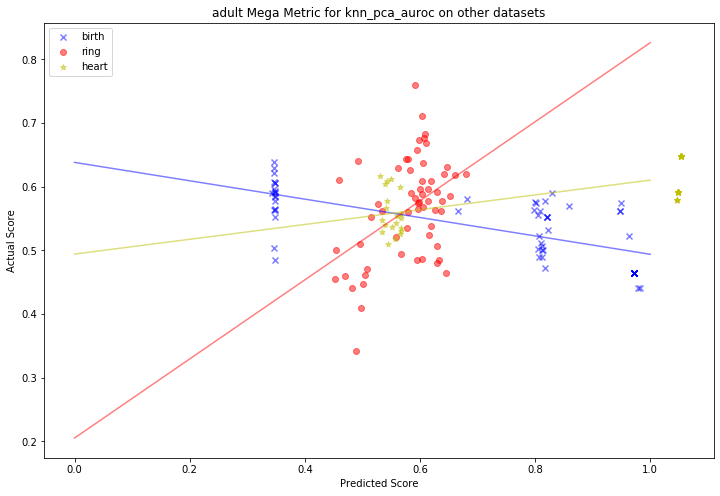

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

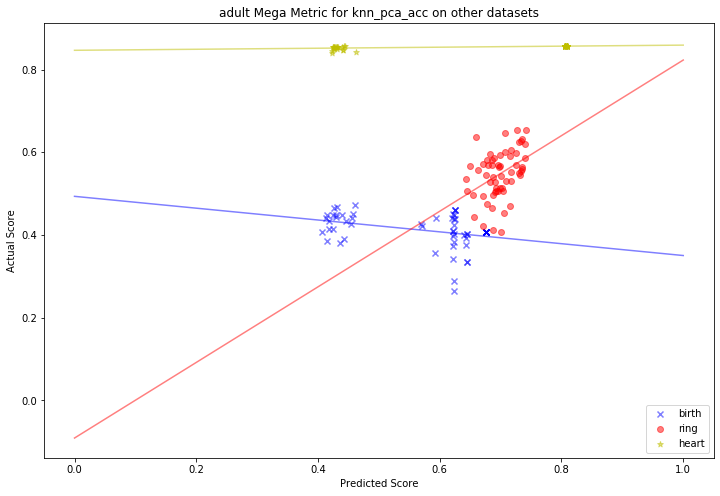

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using

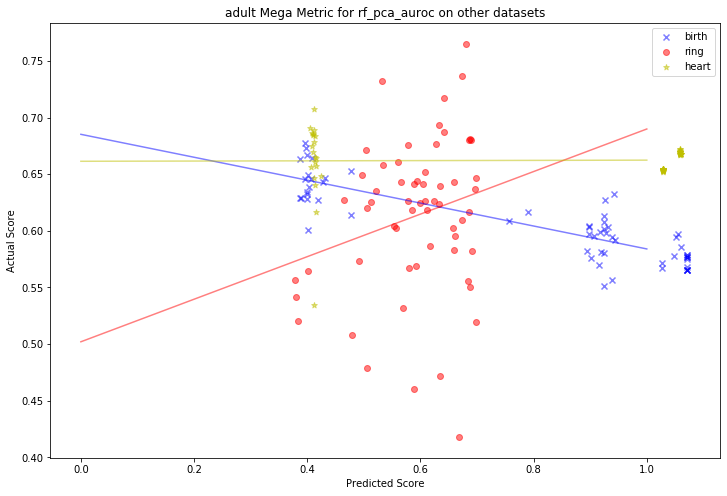

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

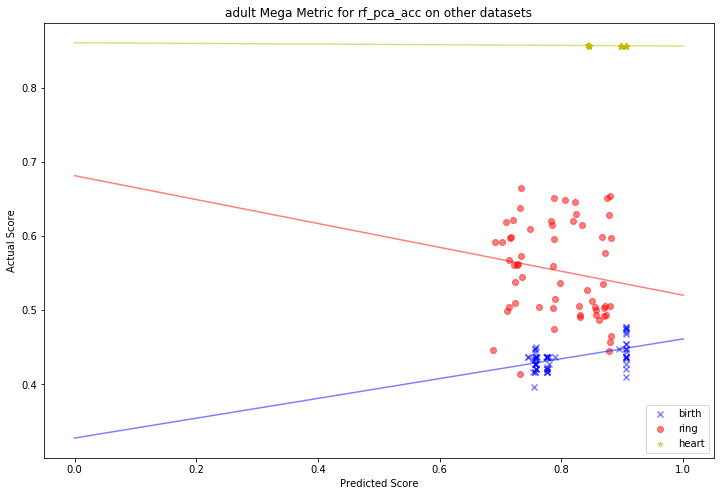

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.22.2.post1 when using v

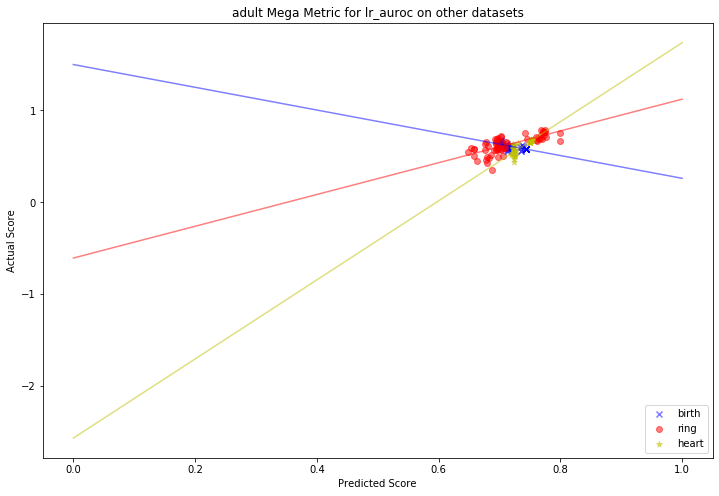

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

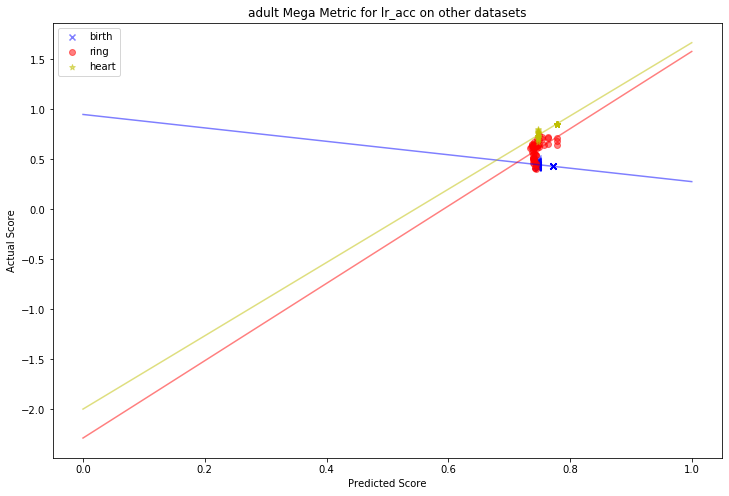

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

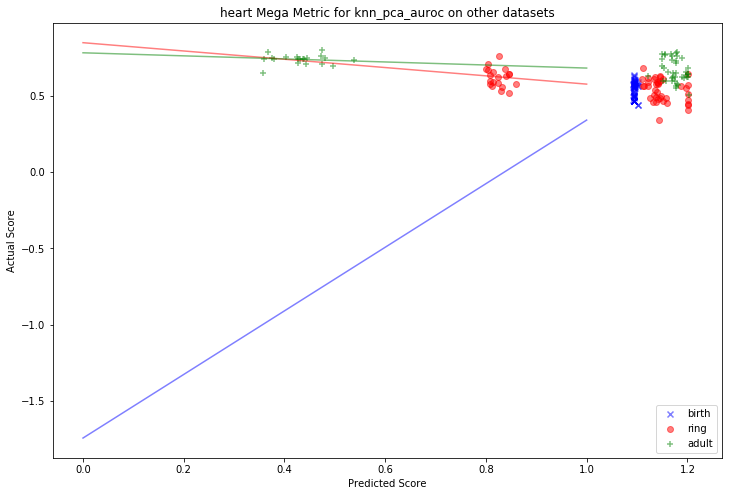

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

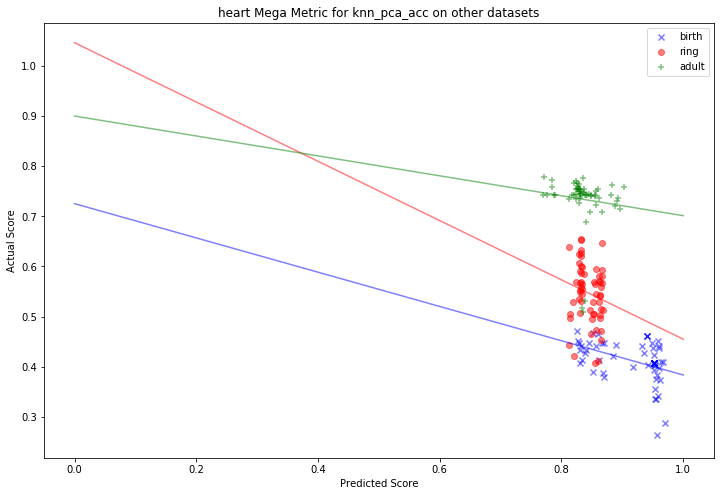

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

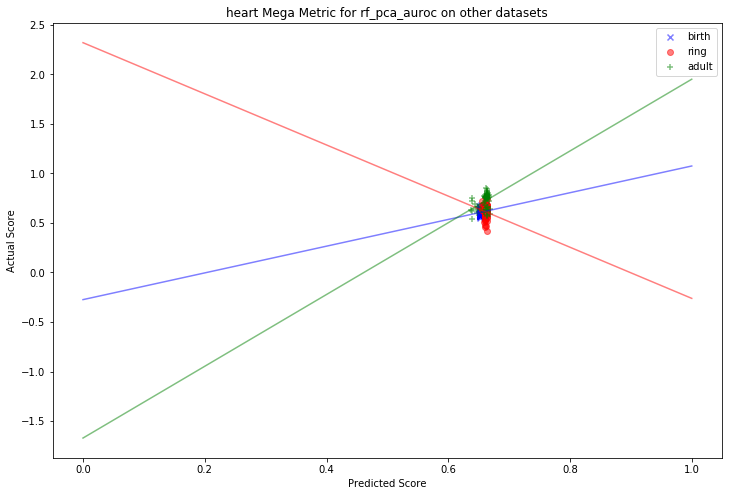

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.22.2.post1 when using v

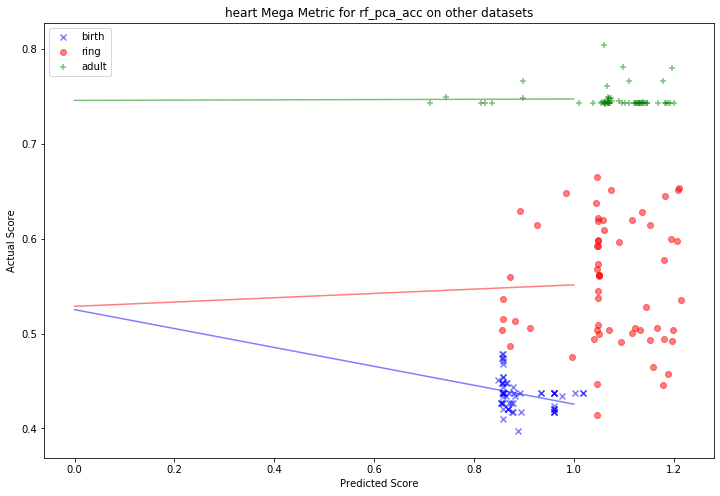

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

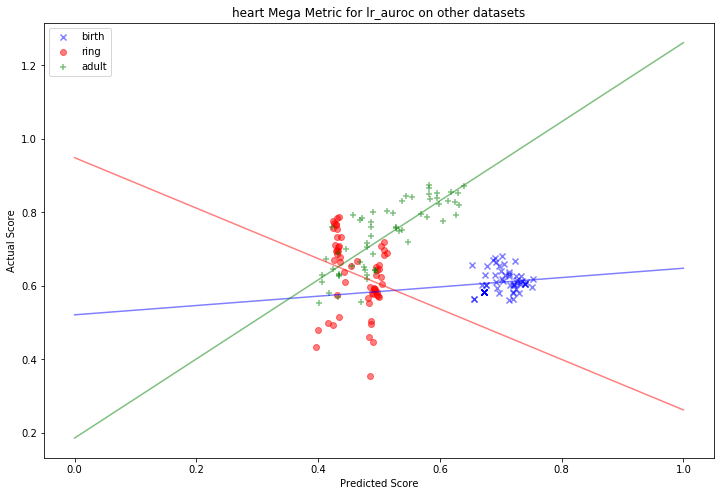

/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sillander/anaconda3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using versio

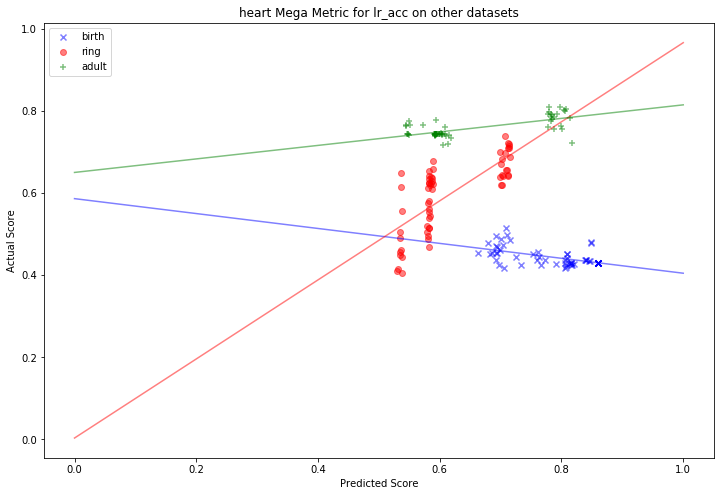

In [9]:
for _, _, _, _, label in plot_info:
    for target in accs.columns[3:]:
        cross_test(label, target)

In [10]:
# Using one utility mega metric, can I predict another mega metric